# Palmprint Recognition Dengan SimpleCNN dan Mobilenetv2

disusun oleh: kelompok 99
1. Natasha Adinda Cantika (2312120)
2. Futih Millati Addinillah (2309445)

## Pendahuluan
Palmprint Recognition adalah sistem identifikasi biometrik yang memanfaatkan karakteristik unik pada telapak tangan, seperti garis utama (principal lines), kerutan (wrinkles), dan tekstur kulit. Teknologi pengenalan telapak tangan otomatis mulai berkembang pesat sejak dipelopori oleh David Zhang (dari Hong Kong Polytechnic University) pada sekitar tahun 1998 - 2003 melalui pengembangan perangkat pemindai dan algoritma ekstraksi fitur yang sistematis.

## Metodologi dan Cara Kerja
Sistem ini bekerja dengan mengekstraksi fitur morfologi dari citra telapak tangan. Fitur-fitur tersebut kemudian dipelajari oleh model Deep Learning untuk mengenali pola identitas subjek. Dalam eksperimen ini, kami membandingkan tiga arsitektur model dengan karakteristik yang berbeda:
1. SimpleCNN (Baseline): Digunakan sebagai titik acuan (baseline).
Model ini memiliki arsitektur sederhana untuk menguji sejauh mana algoritma konvensional mampu menangani data sebelum beralih ke arsitektur yang lebih kompleks.
2. MobileNet: Dipilih karena efisiensinya.
MobileNet menggunakan depthwise separable convolutions yang membuatnya sangat ringan dan cepat, namun tetap memiliki performa tinggi (sering dibandingkan dengan efisiensi EfficientNet). Model ini sangat ideal untuk implementasi pada perangkat mobile.
3. Dataset: Birjand University Mobile Palmprint Database (BUMP)
Eksperimen ini menggunakan dataset dari Kaggle, yaitu Birjand University Mobile Palmprint Database (BUMP). Karakteristik dataset ini meliputi:
    - Klasifikasi: Terdiri dari berbagai kelas (individu).
    - Variasi Sesi: Mencakup foto dari Sesi 1 (kode f/first) dan Sesi 2 (kode s/second) untuk memberikan tantangan variasi waktu pengambilan.
    - Lateralitas: Mencakup citra tangan kanan dan tangan kiri untuk setiap subjek.

## Tujuan
Proyek ini bertujuan untuk menghasilkan model yang robust (tangguh), yang mampu mempertahankan akurasi tinggi dalam mengenali identitas manusia meskipun citra memiliki noise (gangguan), variasi pencahayaan, atau kualitas tangkapan kamera yang beragam.

## Hasil dan Pembahasan

Sebelum memulai, langkah pertama yang dilakukan adalah mengimport seluruh library yang diperlukan seperti cv2 untuk pengolahan citra, tensorflow karena kita perlu model CNN, mobilenet, lalu library pendukung lainnya untuk plotting, untuk melakukan perhitungan matematika, dan untuk evaluasi model.

In [9]:
# --- LANGKAH 1: Download dan Ekstrak Dataset di Colab ---
import os
import zipfile
import gdown

# ID file dari link Google Drive yang Anda berikan
file_id = '1XgPtdtaCAsJ78uszoFHb4hhcEt8Jqe0k'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'palm_dataset.zip'

# Download file
if not os.path.exists(output):
    print("Mendownload dataset...")
    gdown.download(url, output, quiet=False)

# Ekstrak file zip
extract_path = '/content/dataset_raw'
if not os.path.exists(extract_path):
    print("Mengekstrak dataset...")
    os.makedirs(extract_path)
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Ekstraksi selesai.")
else:
    print("Dataset sudah diekstrak.")

# Cek isi folder untuk memastikan struktur
print(f"Isi folder ekstraksi: {os.listdir(extract_path)}")

Mendownload dataset...


Downloading...
From (original): https://drive.google.com/uc?id=1XgPtdtaCAsJ78uszoFHb4hhcEt8Jqe0k
From (redirected): https://drive.google.com/uc?id=1XgPtdtaCAsJ78uszoFHb4hhcEt8Jqe0k&confirm=t&uuid=119e4c42-0eb6-4d92-97cb-1df5dd956788
To: /content/palm_dataset.zip
100%|██████████| 1.77G/1.77G [00:34<00:00, 51.9MB/s]


Mengekstrak dataset...
Ekstraksi selesai.
Isi folder ekstraksi: ['Birjand University Mobile Palmprint Database (BMPD)']


### Import library

In [ ]:
# Import library yg diperlukan
import os
import cv2
import numpy as np
import random
import math
import tensorflow as tf
import shutil
import seaborn as sns
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Flatten, Input
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# untuk save model
from google.colab import files

In [11]:
# ---------------------
#       CONFIG
# ---------------------

# Menentukan RAW_PATH secara otomatis berdasarkan hasil ekstraksi
# Kita mencari folder di dalam '/content/dataset_raw'
base_extract_path = '/content/dataset_raw'
contents = [os.path.join(base_extract_path, item) for item in os.listdir(base_extract_path) if os.path.isdir(os.path.join(base_extract_path, item))]

# Jika zip membungkus folder lain (misal: 'dataset_raw/test_local/'), gunakan folder tersebut
if len(contents) == 1:
    RAW_PATH = contents[0]
else:
    # Jika gambar/kelas langsung ada di root zip
    RAW_PATH = base_extract_path

print(f"RAW_PATH diatur ke: {RAW_PATH}")

# Gunakan path absolut '/content/...' untuk output agar aman di Colab
SPLIT_PATH = '/content/dataset_splitted'
PREPROCESSED_PATH = '/content/preprocessed_dataset'

# Buat direktori output jika belum ada
if not os.path.exists(SPLIT_PATH):
    os.makedirs(SPLIT_PATH)
if not os.path.exists(PREPROCESSED_PATH):
    os.makedirs(PREPROCESSED_PATH)


# set random seed untuk mengunci hasil
# Tentukan angka kunci (bisa angka berapa saja, misal 42)
SEED_VALUE = 42

# 1. Atur seed untuk Python environment
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Atur seed untuk library random bawaan Python
random.seed(SEED_VALUE)

# 3. Atur seed untuk NumPy (pengolahan array)
np.random.seed(SEED_VALUE)

# 4. Atur seed untuk TensorFlow (bobot model & training)
tf.random.set_seed(SEED_VALUE)

# (Opsional) Memaksa TensorFlow menggunakan operasi deterministik
# Ini membuat hasil 100% sama tapi mungkin sedikit memperlambat training
tf.config.experimental.enable_op_determinism()

print(f"Random Seed telah dikunci di angka {SEED_VALUE}. Hasil training akan konsisten.")

RAW_PATH diatur ke: /content/dataset_raw/Birjand University Mobile Palmprint Database (BMPD)
Random Seed telah dikunci di angka 42. Hasil training akan konsisten.


### Load dataset

Saat dataset di load, resize ukurannya dengan padding supaya rasio gambar tidak rusak dan fitur tetap terjaga.

In [12]:
# load dataset
def load_dataset(path):
    data, labels = [], []

    # jika path tidak ditemukan
    if not os.path.exists(path):
        print("Path does not exist.")
        return np.array(data), np.array(labels)

    for label in os.listdir(path):
        label_path = os.path.join(path, label)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                img_path = os.path.join(label_path, img_name)
                img = tf.image.decode_image(open(img_path, "rb").read(), channels=3)
                if img is not None:
                    resized_img = tf.image.resize_with_pad(img, 225, 225)
                    data.append(resized_img)
                    labels.append(label)
    return np.array(data), np.array(labels)

Dataset loaded with 1600 images.


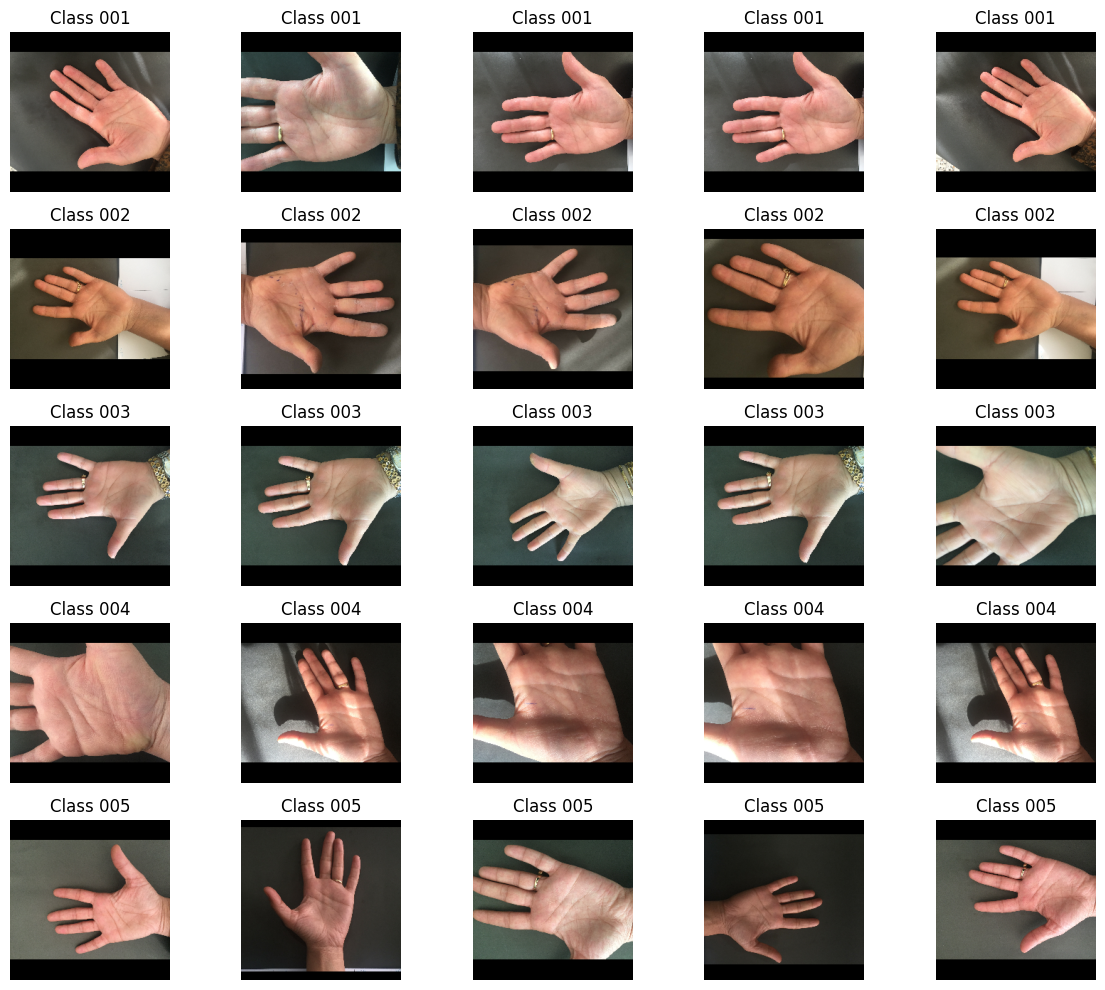

In [13]:
data, labels = load_dataset(RAW_PATH)
print(f"Dataset loaded with {len(data)} images.")

if len(data) == 0:
    print("No images found to display.")
else:
    unique_classes = np.unique(labels)[:5]      # ambil 5 kelas pertama saja
    num_display = 5                             # 5 gambar per kelas

    plt.figure(figsize=(12, 10))

    plot_index = 1
    for cls in unique_classes:
        # ambil indeks gambar milik kelas ini
        class_indices = np.where(labels == cls)[0][:num_display]

        for idx in class_indices:
            img = data[idx]

            # normalisasi dahulu, karena maptlotlib mengharapkan pizel di [0, 1]
            img_norm = img / 255.0

            plt.subplot(len(unique_classes), num_display, plot_index)
            plt.imshow(img_norm)
            plt.title(f"Class {cls}")
            plt.axis("off")
            plot_index += 1

    plt.tight_layout()
    plt.show()

Sebelum masuk ke training dan praproses, dataset di split dengan rumus:
- session 1: 70% train 30% val
- session 2: 100% test

Dengan formula split ini diharapkan tidak ada data leakage dari foto sesi yang sama. Foto sesi kedua diambil menjadi datatest karena foto yang ada di masing-masing sesi cukup banyak yang terlihat sama, baik dari pencahayaan dan rotasi foto.

In [14]:
from collections import defaultdict

def split_dataset_session_based(input_path, output_path):
    print("splitting dataset: ", {input_path})
    # print("splitting dataset: ", {output_path})

    train_ratio = 0.70   # dari session F
    val_ratio   = 0.30   # dari session F (sisanya)

    print("Splitting dataset (SESSION-BASED)...")

    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(output_path, split), exist_ok=True)

    split_counts = {"train": defaultdict(int),
                    "val": defaultdict(int),
                    "test": defaultdict(int)}

    for label in os.listdir(input_path):
        label_path = os.path.join(input_path, label)
        if not os.path.isdir(label_path):
            continue

        images = os.listdir(label_path)

        # pisahkan berdasar session
        f_imgs = [img for img in images if "_F_" in img]
        s_imgs = [img for img in images if "_S_" in img]

        # session F → train + val
        train_imgs, val_imgs = train_test_split(
            f_imgs,
            test_size=val_ratio,
            random_state=42,
            shuffle=True
        )

        # session S → test semua
        test_imgs = s_imgs

        mapping = {
            "train": train_imgs,
            "val": val_imgs,
            "test": test_imgs
        }

        for split_name, split_imgs in mapping.items():
            split_label_dir = os.path.join(output_path, split_name, label)
            os.makedirs(split_label_dir, exist_ok=True)

            for img in split_imgs:
                src = os.path.join(label_path, img)
                dst = os.path.join(split_label_dir, img)
                shutil.copy2(src, dst)

            split_counts[split_name][label] += len(split_imgs)

    print("\n=== SUMMARY ===")
    for split_name in ["train", "val", "test"]:
        total_images = sum(split_counts[split_name].values())
        print(f"{split_name.upper():>5} : {total_images} images")
        for label, count in split_counts[split_name].items():
            print(f"    Class {label}: {count} images")
    print("\nDone.")


In [15]:
split_dataset_session_based(RAW_PATH, SPLIT_PATH)

splitting dataset:  {'/content/dataset_raw/Birjand University Mobile Palmprint Database (BMPD)'}
Splitting dataset (SESSION-BASED)...

=== SUMMARY ===
TRAIN : 560 images
    Class 028: 14 images
    Class 039: 14 images
    Class 022: 14 images
    Class 017: 14 images
    Class 009: 14 images
    Class 016: 14 images
    Class 007: 14 images
    Class 031: 14 images
    Class 036: 14 images
    Class 026: 14 images
    Class 005: 14 images
    Class 024: 14 images
    Class 020: 14 images
    Class 001: 14 images
    Class 003: 14 images
    Class 012: 14 images
    Class 034: 14 images
    Class 013: 14 images
    Class 040: 14 images
    Class 019: 14 images
    Class 023: 14 images
    Class 032: 14 images
    Class 010: 14 images
    Class 011: 14 images
    Class 018: 14 images
    Class 029: 14 images
    Class 002: 14 images
    Class 041: 14 images
    Class 015: 14 images
    Class 006: 14 images
    Class 035: 14 images
    Class 037: 14 images
    Class 030: 14 images
    C

In [16]:
def load_split(split_dir):
    data, labels = [], []
    label_encoder = LabelEncoder()

    for label in os.listdir(split_dir):
        label_path = os.path.join(split_dir, label)
        if not os.path.isdir(label_path):
            continue

        for img_name in os.listdir(label_path):
            img_path = os.path.join(label_path, img_name)
            img = tf.image.decode_image(open(img_path, "rb").read(), channels=1)

            if img is None:
                continue

            img = tf.image.resize_with_pad(img, 256, 256)
            data.append(img)
            labels.append(label)

    labels = label_encoder.fit_transform(labels)

    data = np.array(data, dtype="float32") / 255.0
    data = np.expand_dims(data, axis=-1)

    return data, np.array(labels), label_encoder

In [17]:
train_data, train_labels, label_encoder = load_split(os.path.join(SPLIT_PATH, "train"))
val_data,   val_labels, _   = load_split(os.path.join(SPLIT_PATH, "val"))
test_data,  test_labels, _  = load_split(os.path.join(SPLIT_PATH, "test"))

## Model Baseline SimpleCNN

Model simpleCNN dipilih untuk model baseline karena arsitekturnya yang masih bisa dibuat simpel. Disini kami menggunakan 2 layer konvolusional dan 1 layer dense.

In [18]:
def train_cnn(num_classes):
    # pastikan graph lama dibersihkan
    tf.keras.backend.clear_session()

    # 1) Bangun model (grayscale: 1 channel)
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    # 2) Compile
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [19]:
print("Training baseline CNN...")
cnn_model = train_cnn(len(np.unique(train_labels)))

cnn_model.summary()

cnn_history = cnn_model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=30,
    batch_size=32
)

cnn_model.save('cnn_model.h5')
files.download('cnn_model.h5')

Training baseline CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,703,592 (6.50 MB)

 Trainable params: 1,703,592 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.0183 - loss: 3.7022 - val_accuracy: 0.0542 - val_loss: 3.6806
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.0615 - loss: 3.6657 - val_accuracy: 0.0833 - val_loss: 3.5515
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.1304 - loss: 3.3713 - val_accuracy: 0.2667 - val_loss: 3.1315
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.2755 - loss: 2.8547 - val_accuracy: 0.4167 - val_loss: 2.3981
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4476 - loss: 2.1472 - val_accuracy: 0.5417 - val_loss: 1.7814
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.5627 - loss: 1.5862 - val_accuracy: 0.6500 - val_loss: 1.4793
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.7104 - loss: 1.0931 - val_accuracy: 0.6750 - val_loss: 1.2872
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.7491 - loss: 0.8793 - val_accuracy: 0.7042 - 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
def plot_training(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))

    # accuracy
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Val Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # loss
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

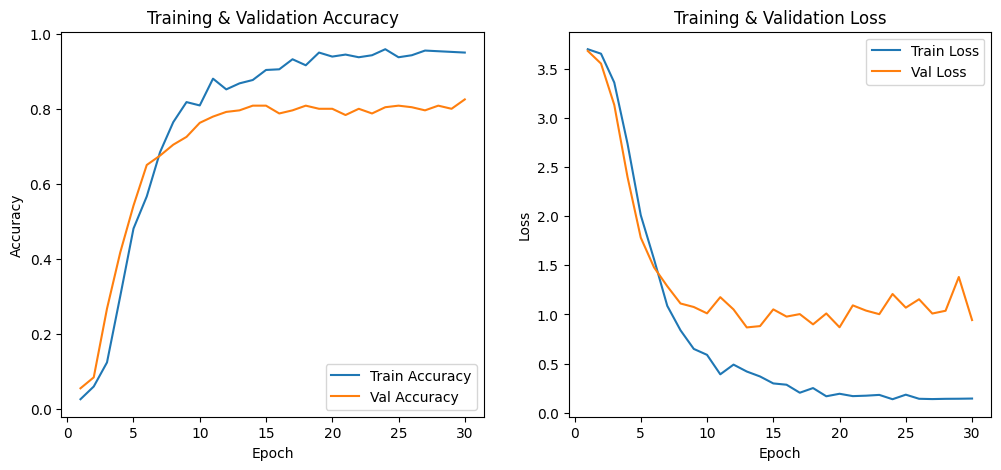

In [21]:
plot_training(cnn_history)

Hasil evaluasi

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5979 - loss: 2.4226
Test accuracy: 0.6050


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


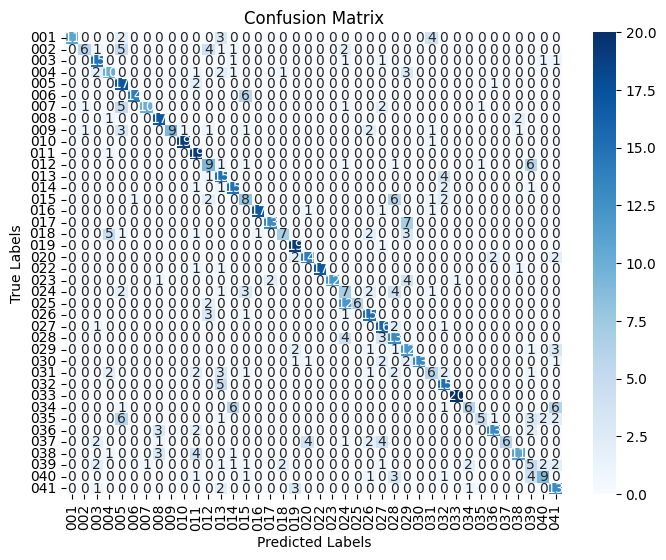

Classification Report:
               precision    recall  f1-score   support

         001       1.00      0.55      0.71        20
         002       0.75      0.30      0.43        20
         003       0.62      0.75      0.68        20
         004       0.50      0.50      0.50        20
         005       0.40      0.85      0.55        20
         006       0.93      0.70      0.80        20
         007       0.91      0.50      0.65        20
         008       0.68      0.85      0.76        20
         009       1.00      0.45      0.62        20
         010       0.95      0.95      0.95        20
         011       0.56      0.95      0.70        20
         012       0.41      0.45      0.43        20
         013       0.41      0.75      0.53        20
         014       0.58      0.75      0.65        20
         015       0.35      0.40      0.37        20
         016       0.94      0.85      0.89        20
         017       0.87      0.65      0.74        20
   

In [22]:
# Evaluate the model on the test set
test_loss, test_acc = cnn_model.evaluate(test_data, test_labels)
print(f"Test accuracy: {test_acc:.4f}")

# Generate predictions for the test set
test_preds = cnn_model.predict(test_data)
test_preds_classes = np.argmax(test_preds, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds_classes)

# Decode class indices back to class labels
class_labels = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(test_labels, test_preds_classes, target_names=class_labels)
print("Classification Report:\n", report)

## Praproses dataset

Langkah praproses yang dilakukan dibagi menjadi 2 bagian
1. Enhance fitur : Ekstraksi ROI & Normalisasi Cahaya
2. Tingkatkan Keragaman Dataset: Augmentasi

### 1. Enhance Fitur

#### Ekstraksi ROI

Cara utama yang akan digunakan untuk ekstraksi ROI adalah dengan mencari valley points lalu menarik garis ke pusat telapak tangan lalu memotong ROI berdasarkan titik pusat tersebut. Pendekatan pertama yang digunakan adalah dengan Convexity Defect untuk mencari valley point dan Vector Geometry yang menggunakan matematika vektor untuk menghitung garis tegak lurus (normal vector) dari garis sela jari.

Contoh palm ROI berhasil


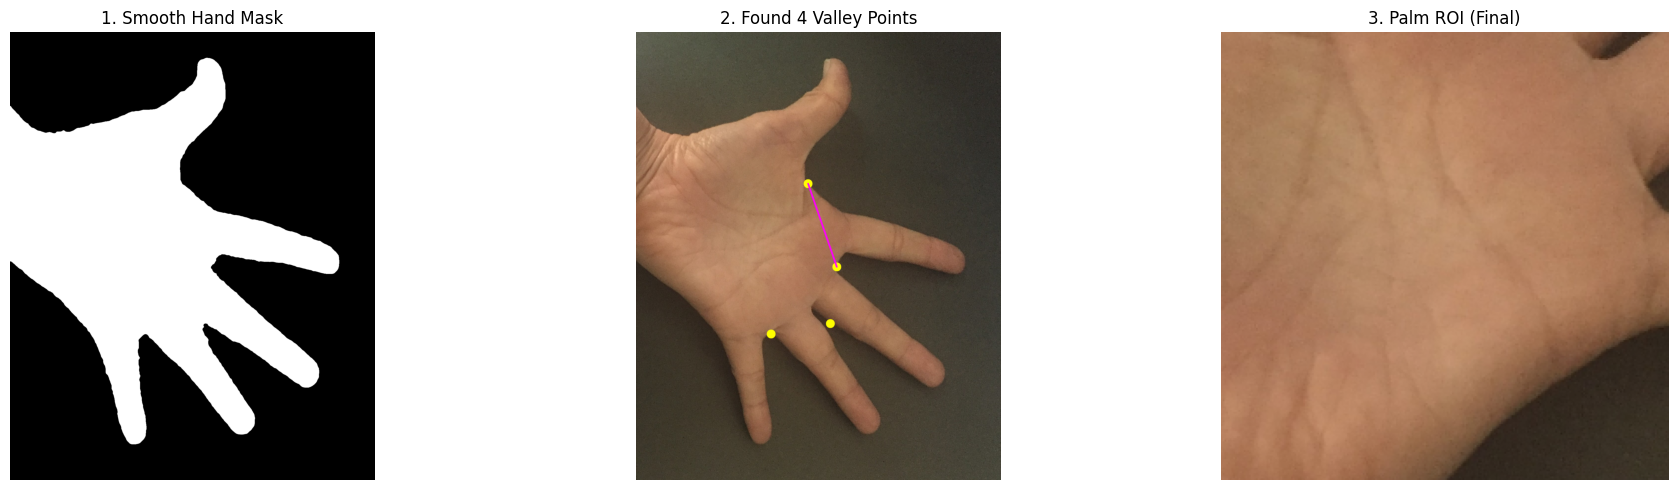

✅ Palm ROI berhasil diekstraksi
Contoh palm ROI gagal


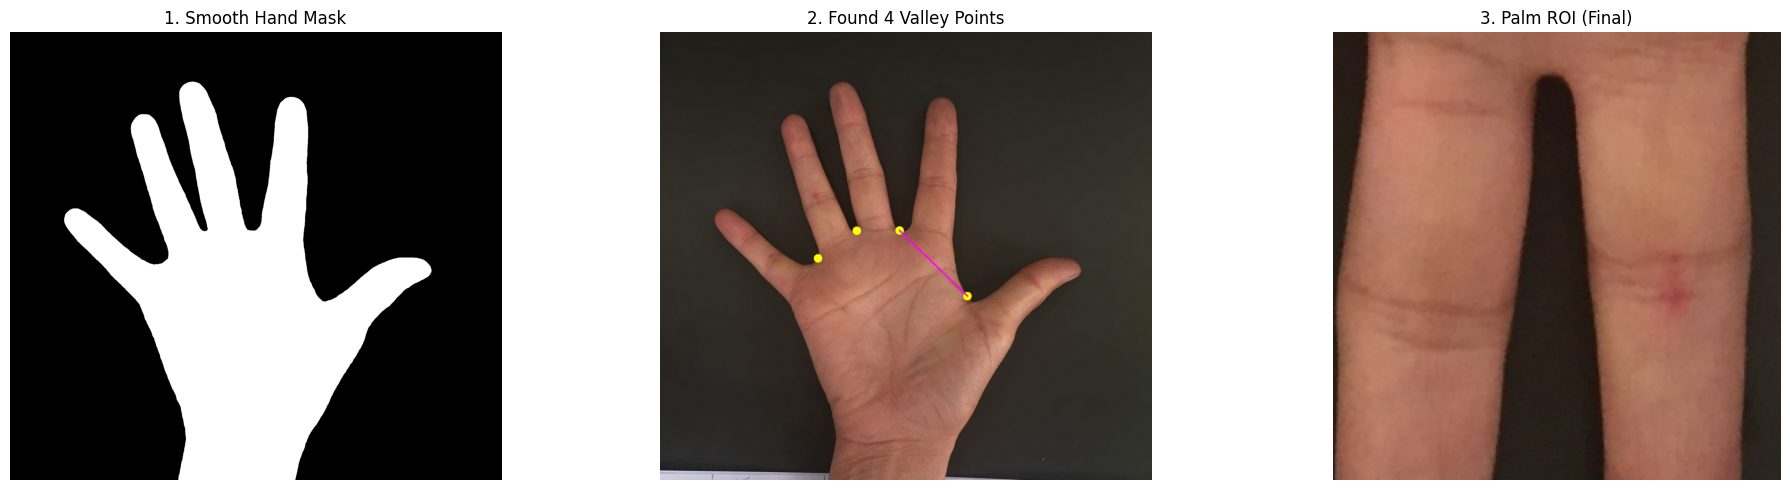

✅ Palm ROI berhasil diekstraksi


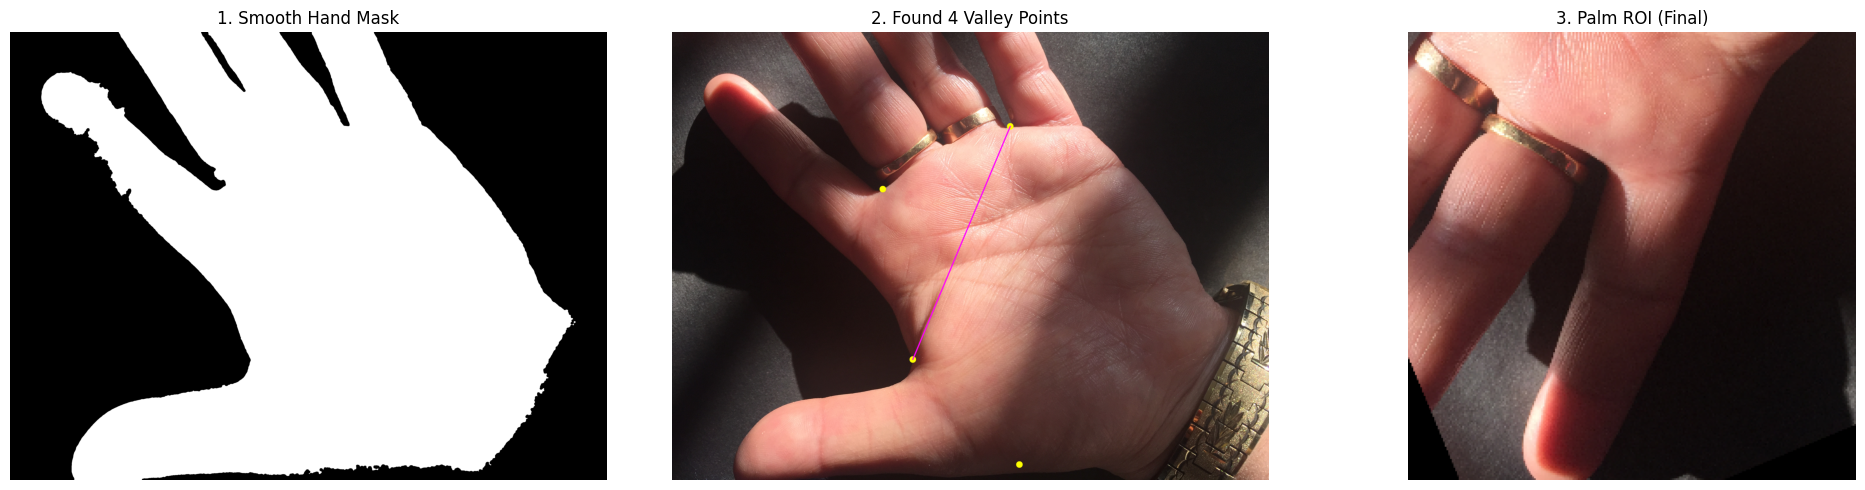

✅ Palm ROI berhasil diekstraksi


In [23]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

# ==========================================
# 1. SETTINGS & PARAMETERS
# ==========================================

YCrCb_SKIN_LOWER = np.array([30, 138, 80], dtype=np.uint8)
YCrCb_SKIN_HIGHER = np.array([255, 180, 127], dtype=np.uint8)

DEFECT_DEPTH_THRESHOLD = 20   # kedalaman cekungan (penting!)
PALM_ROI_SIZE = 256


# ==========================================
# 2. CORE FUNCTIONS
# ==========================================

def get_ultra_clean_mask(img_bgr):
    """Masking kulit + pembersihan kontur"""
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    mask = cv2.inRange(ycrcb, YCrCb_SKIN_LOWER, YCrCb_SKIN_HIGHER)

    mask = cv2.medianBlur(mask, 9)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    clean = np.zeros_like(mask)

    if contours:
        largest = max(contours, key=cv2.contourArea)
        cv2.drawContours(clean, [largest], -1, 255, -1)

    return clean


def get_convex_valleys(hand_mask):
    """Ekstraksi sela jari berdasarkan convexity defect"""
    contours, _ = cv2.findContours(hand_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return []

    cnt = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(cnt, returnPoints=False)

    if hull is None or len(hull) < 3:
        return []

    defects = cv2.convexityDefects(cnt, hull)
    valleys = []

    if defects is None:
        return valleys

    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]
        depth = d / 256.0

        if depth < DEFECT_DEPTH_THRESHOLD:
            continue

        far = tuple(cnt[f][0])
        valleys.append(far)

    return valleys


def filter_thumb_valley(pts, hand_mask):
    """Buang valley ibu jari (paling pinggir)"""
    if len(pts) <= 4:
        return pts

    h, w = hand_mask.shape
    cx = w // 2

    pts = sorted(pts, key=lambda p: abs(p[0] - cx))
    return pts[:4]


def extract_palm_roi(img, pts, size=PALM_ROI_SIZE):
    """
    Ekstraksi ROI telapak berbasis geometri vektor sela jari.
    Menggunakan titik sela jari telunjuk-tengah (pts[0]) dan manis-kelingking (pts[2]).
    """
    if len(pts) < 3:
        return None

    # 1. Urutkan titik secara anatomis (berdasarkan sumbu X jika horizontal, Y jika vertikal)
    # Untuk tangan di screenshot (fingers pointing right), urutkan berdasarkan Y
    pts = sorted(pts, key=lambda p: p[1])

    # Ambil titik acuan standar (V1 dan V3)
    p1 = np.array(pts[0], dtype=np.float32) # Sela telunjuk-tengah
    p2 = np.array(pts[2], dtype=np.float32) # Sela manis-kelingking

    # 2. Hitung vektor arah dan titik tengah
    v_dir = p2 - p1
    dist = np.linalg.norm(v_dir)
    midpoint = (p1 + p2) / 2

    # 3. Hitung sudut rotasi agar garis sela jari menjadi horizontal
    angle = math.degrees(math.atan2(v_dir[1], v_dir[0]))

    # 4. Tentukan arah "Ke Dalam Telapak" (Vektor Normal)
    # Kita putar vektor arah sebesar 90 derajat
    # Jika arah tidak tepat ke tengah telapak, ganti -v_dir[1] menjadi v_dir[1]
    normal_vec = np.array([-v_dir[1], v_dir[0]])
    normal_vec = normal_vec / np.linalg.norm(normal_vec) # Normalisasi

    # 5. Tentukan Pusat ROI (Geser dari midpoint ke arah normal)
    # k = 0.5 - 0.8 adalah konstanta pergeseran ke tengah telapak
    k_shift = 0.6
    roi_center = midpoint + (normal_vec * dist * k_shift)

    # 6. Lakukan Rotasi Gambar pada pusat ROI
    M = cv2.getRotationMatrix2D((float(roi_center[0]), float(roi_center[1])), angle, 1.0)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

    # 7. Cropping Persegi (ROI)
    roi_side = int(dist * 1.1) # Ukuran sisi disesuaikan dengan lebar tangan

    x = int(roi_center[0] - roi_side / 2)
    y = int(roi_center[1] - roi_side / 2)

    roi = rotated[max(0, y):y + roi_side, max(0, x):x + roi_side]

    if roi.size == 0 or roi.shape[0] < 10:
        return None

    return cv2.resize(roi, (size, size))


# ==========================================
# 3. RUNTIME & VISUALIZATION
# ==========================================

def extract_and_visualize_palm_roi(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError("Gambar tidak ditemukan")

        # Step 1: Mask
        mask_clean = get_ultra_clean_mask(img)

        # Step 2: Convex Hull Valley
        pts = get_convex_valleys(mask_clean)
        pts = filter_thumb_valley(pts, mask_clean)

        # Step 3: Palm ROI
        palm_roi = extract_palm_roi(img, pts)

        # ================= VISUAL =================
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 3, 1)
        plt.title("1. Smooth Hand Mask")
        plt.imshow(mask_clean, cmap='gray')
        plt.axis("off")

        # Visual convex hull valley
        vis = img.copy()
        for p in pts:
            cv2.circle(vis, p, 18, (0, 255, 255), -1)

        if len(pts) >= 3:
            cv2.line(vis, pts[0], pts[2], (255, 0, 255), 5)

        plt.subplot(1, 3, 2)
        plt.title(f"2. Found {len(pts)} Valley Points")
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.axis("off")

        if palm_roi is not None:
            plt.subplot(1, 3, 3)
            plt.title("3. Palm ROI (Final)")
            plt.imshow(cv2.cvtColor(palm_roi, cv2.COLOR_BGR2RGB))
            plt.axis("off")

        plt.tight_layout()
        plt.show()

        if palm_roi is not None:
            print("✅ Palm ROI berhasil diekstraksi")
        else:
            print("⚠️ Palm ROI gagal")

    except Exception as e:
        print("Error:", e)

# ==========================================
# roi berhasil
print("Contoh palm ROI berhasil")
extract_and_visualize_palm_roi(r'/content/dataset_raw/Birjand University Mobile Palmprint Database (BMPD)/010/010_F_L_38.JPG')  # Gambar tanpa tangan

# ==========================================
# roi gagal
print("Contoh palm ROI gagal")
extract_and_visualize_palm_roi(r'/content/dataset_raw/Birjand University Mobile Palmprint Database (BMPD)/007/007_S_R_10.JPG')
extract_and_visualize_palm_roi(r'/content/dataset_raw/Birjand University Mobile Palmprint Database (BMPD)/006/006_F_L_32.JPG')

Dari visualisasi hasil, langkah yang terjadi saat praproses sebelum pemotongan ROI adalah:
1. Penerapan skin masking untuk mencari tahu kontur tangan.
2. Garis ungu adalah reference axis (sumbu referensi), garis ini sebagai penentu lebar roi yang akan dibuat dan titik tengah dari garis ini diambil sebagai centroid. Selain itu, kemiringan dari garis ini juga dijadikan patokan rotasi gambar.
3. Hasil pemotongan ROI berdasarkan reference axis.

dari hasil 3 contoh sampel ini dapat disimpulkan bahwa metode ini masih kurang robust untuk gambar tangan yang terpotong dan bahkan untuk tangan yang terlihat utuhpun masih ada kesalahan penentuan reference axis, hal ini karena reference axis diambil berdasarkan point, lebih tepatnya pts[0] dan pts[2] padahal point tidak selalu berurutan dan ada kemungkinan valley point yang ditemukan lebih dari 4.

Maka dari itu, di pendekatan kedua yaitu dengan metode Center of Mass dari mask yang dihasilkan untuk menjadi centroid. Lalu, garis lurus ditarik dari valley point tengah ke centroid untuk menentukan lebar tangan, dengan ini pembentukan kotak ROI dapat menyesuaikan dengan besar tangan.

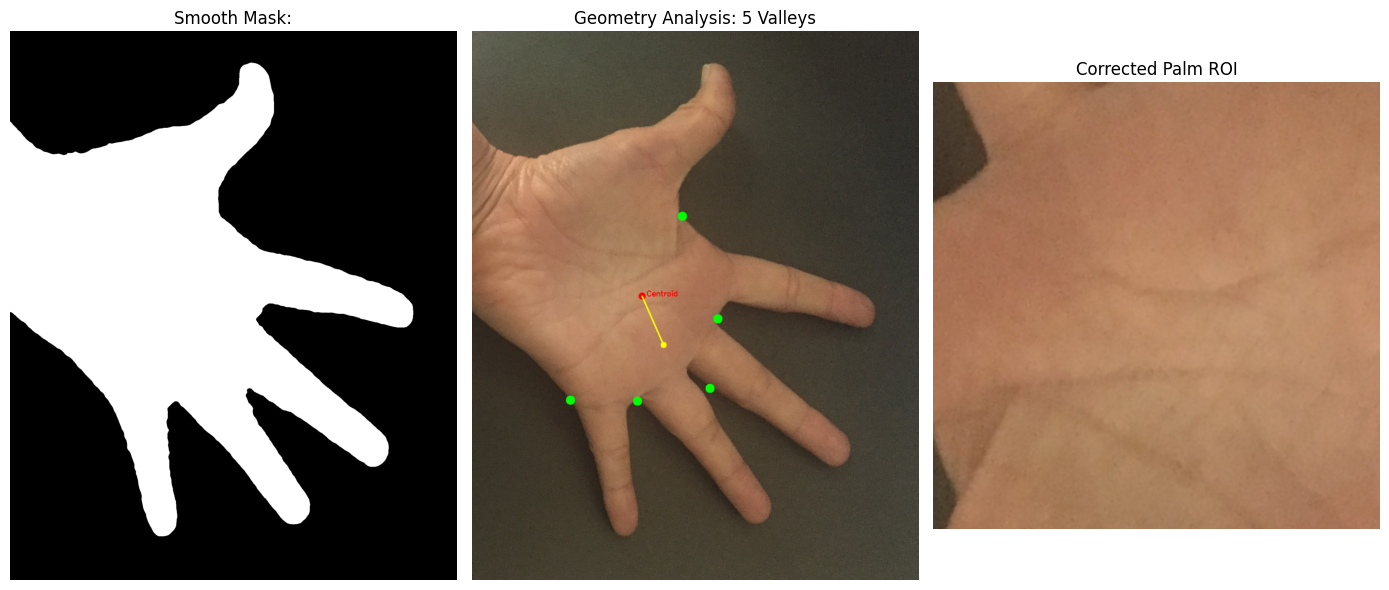

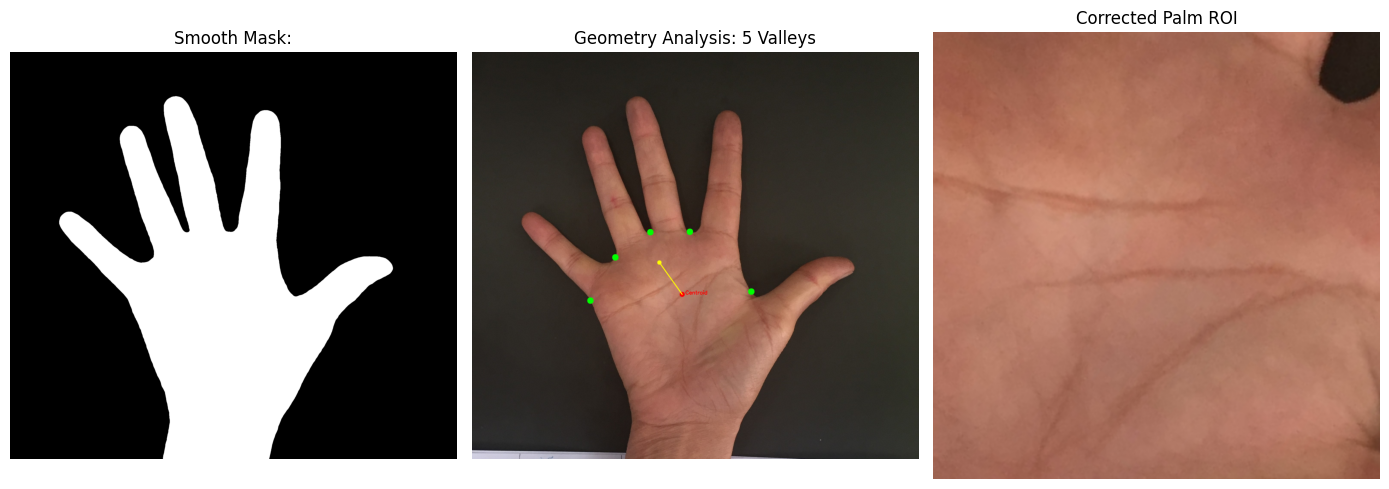

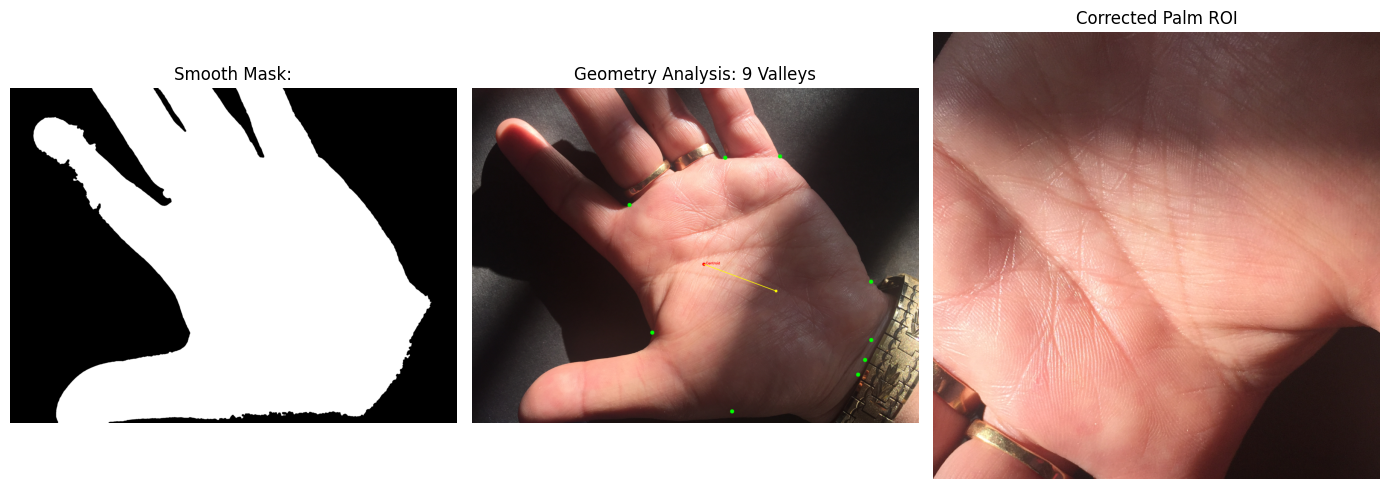

In [24]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt

# ==========================================
# 1. SETTINGS
# ==========================================
YCrCb_SKIN_LOWER = np.array([30, 138, 80], dtype=np.uint8)
YCrCb_SKIN_HIGHER = np.array([255, 180, 127], dtype=np.uint8)
PALM_ROI_SIZE = 600

# ==========================================
# 2. ROBUST FUNCTIONS
# ==========================================

def to_int_pair(point):
    """Helper: Memastikan koordinat adalah tuple integer Python (bukan numpy)"""
    return (int(point[0]), int(point[1]))

def get_hand_mask_centroid(mask):
    """Mencari titik tengah (Center of Mass) dari tangan."""
    M = cv2.moments(mask)
    if M["m00"] == 0: return None
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    return (cx, cy)

def get_clean_mask(img):
    """Masking standar + Morphological Ops"""
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    mask = cv2.inRange(ycrcb, YCrCb_SKIN_LOWER, YCrCb_SKIN_HIGHER)
    mask = cv2.medianBlur(mask, 11)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    clean = np.zeros_like(mask)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        cv2.drawContours(clean, [largest], -1, 255, -1)
    return clean

def get_robust_valleys(mask):
    """
    Mencari valley points dengan filter jarak (Clustering).
    """
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return []
    cnt = max(contours, key=cv2.contourArea)

    hull = cv2.convexHull(cnt, returnPoints=False)
    defects = cv2.convexityDefects(cnt, hull)
    if defects is None: return []

    raw_pts = []
    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]
        depth = d / 256.0
        if depth > 15: # Depth threshold agak longgar, nanti difilter outlier
            raw_pts.append(tuple(cnt[f][0]))

    if len(raw_pts) < 3: return raw_pts

    # --- FILTER OUTLIER (Titik Pergelangan) ---
    valleys_center = np.mean(raw_pts, axis=0)

    # Hitung jarak setiap titik ke pusat rata-rata sela jari
    distances = [np.linalg.norm(np.array(p) - valleys_center) for p in raw_pts]
    mean_dist = np.mean(distances)

    final_pts = []
    for i, p in enumerate(raw_pts):
        # Jika jaraknya < 1.5x rata-rata, berarti bergerombol (jari).
        # Jika jauh (pergelangan), dibuang.
        if distances[i] < mean_dist * 1.5:
            final_pts.append(p)

    return final_pts

def extract_roi_using_centroid(img, pts, hand_centroid):
    """
    Ekstraksi ROI menggunakan Centroid Tangan sebagai jangkar arah.
    Memastikan ROI selalu masuk ke dalam telapak, bukan ke jari.
    """
    if len(pts) < 2 or hand_centroid is None: return None

    pts_arr = np.array(pts)
    c_hand = np.array(hand_centroid)

    # 1. Tentukan titik tengah sela jari (Valley Center)
    v_center = np.mean(pts_arr, axis=0)

    # 2. Tentukan Vektor Utama (Sumbu Tangan)
    # Vektor dari Valley Center MENUJU Hand Centroid (Pasti arah ke telapak)
    axis_vector = c_hand - v_center

    # 3. Hitung sudut rotasi
    # Math.atan2 menghasilkan radian, ubah ke derajat.
    # Kita ingin vector ini mengarah vertikal ke bawah (90 derajat)
    angle_rad = math.atan2(axis_vector[1], axis_vector[0])
    angle = math.degrees(angle_rad) - 90

    # 4. Tentukan Pusat ROI
    # Geser dari Valley Center ke arah Hand Centroid sejauh 40%
    roi_center_arr = v_center + (axis_vector * 0.9)

    # --- PERBAIKAN UTAMA: CAST KE INT ---
    roi_center_tuple = (int(roi_center_arr[0]), int(roi_center_arr[1]))

    # 5. Rotasi Gambar pada roi_center
    M = cv2.getRotationMatrix2D(roi_center_tuple, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

    # 6. Tentukan Ukuran Box (Dynamic Sizing)
    max_dist = 0
    for p1 in pts:
        for p2 in pts:
            d = np.linalg.norm(np.array(p1)-np.array(p2))
            if d > max_dist: max_dist = d

    roi_side = int(max_dist * 0.7)
    if roi_side == 0: roi_side = 300

    # Crop
    x = int(roi_center_tuple[0] - roi_side / 2)
    y = int(roi_center_tuple[1] - roi_side / 2)

    roi = rotated[max(0, y):y + roi_side, max(0, x):x + roi_side]

    if roi.size == 0 or roi.shape[0] < 10: return None
    return cv2.resize(roi, (PALM_ROI_SIZE, PALM_ROI_SIZE))

# ==========================================
# 3. RUNTIME
# ==========================================
# Ganti path ini sesuai file Anda

def extract_and_visualize_palm_roi_new(IMAGE_PATH):
    try:
        img = cv2.imread(IMAGE_PATH)
        if img is None: raise Exception("Gambar tidak ditemukan")

        # 1. Masking & Centroid
        mask = get_clean_mask(img)
        centroid = get_hand_mask_centroid(mask)

        # 2. Valley Detection (Robust)
        pts = get_robust_valleys(mask)

        # 3. ROI Extraction (Centroid-Based)
        roi = extract_roi_using_centroid(img, pts, centroid)

        # --- VISUALIZATION ---
        plt.figure(figsize=(14, 6))

        # Plot 1: Analisis Geometri
        vis = img.copy()

        # Gambar Centroid (Merah)
        if centroid:
            cv2.circle(vis, to_int_pair(centroid), 12, (0, 0, 255), -1)
            cv2.putText(vis, "Centroid", (centroid[0]+15, centroid[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)

        # Gambar Titik Valley (Hijau)
        if pts:
            pts_arr = np.array(pts)
            # Gambar rata-rata valley (Titik Kuning)
            v_center = np.mean(pts_arr, axis=0)
            cv2.circle(vis, to_int_pair(v_center), 10, (0, 255, 255), -1)

            # Garis Arah (Kuning) dari Valley ke Centroid
            if centroid:
                cv2.line(vis, to_int_pair(v_center), to_int_pair(centroid), (0, 255, 255), 3)

            for p in pts:
                cv2.circle(vis, to_int_pair(p), 15, (0, 255, 0), -1)

        plt.subplot(1, 3, 1)
        plt.title(f"Smooth Mask:")
        plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.title(f"Geometry Analysis: {len(pts)} Valleys")
        plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Plot 2: ROI Hasil
        plt.subplot(1, 3, 3)
        if roi is not None:
            plt.title("Corrected Palm ROI")
            plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
        else:
            plt.title("ROI Extraction Failed")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        import traceback
        traceback.print_exc() # Print full error trace
        print(f"\nError: {e}")

# ==========================================
# roi berhasil
extract_and_visualize_palm_roi_new(r'/content/dataset_raw/Birjand University Mobile Palmprint Database (BMPD)/010/010_F_L_38.JPG')  # Gambar tanpa tangan
extract_and_visualize_palm_roi_new(r'/content/dataset_raw/Birjand University Mobile Palmprint Database (BMPD)/007/007_S_R_10.JPG')
extract_and_visualize_palm_roi_new(r'/content/dataset_raw/Birjand University Mobile Palmprint Database (BMPD)/006/006_F_L_32.JPG')

Pendekatan kedua ini menghasilkan potongan ROI yang lebih robust terhadap rotasi dan tangan terpotong.

### Filter dan Resize Gambar

In [25]:
# ==========================================
# 1. Config
# ==========================================
INPUT_DIR = '/content/dataset_raw/Birjand University Mobile Palmprint Database (BMPD)'
OUTPUT_DIR = '/content/dataset_processed_augmented'

TARGET_SIZE = (224, 224)
CLAHE_CLIP = 3.0         # Tingkat kontras CLAHE

In [26]:
def enhance_image(roi):
    """Pipeline: Grayscale -> Resize -> CLAHE"""
    # 1. Grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # 2. Resize
    resized = cv2.resize(gray, TARGET_SIZE, interpolation=cv2.INTER_AREA)

    # 3. CLAHE (Contrast Enhancement)
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=(8,8))
    enhanced = clahe.apply(resized)

    return enhanced

In [27]:
# --- Fungsi Helper untuk Augmentasi (DIPERBAIKI) ---

def adjust_brightness(image, value):
    """
    Mengubah kecerahan gambar.
    Bekerja untuk Grayscale maupun RGB.
    Menggunakan cv2.convertScaleAbs untuk otomatis menangani clipping (0-255).
    Parameter 'beta' bertindak sebagai penambah kecerahan.
    """
    return cv2.convertScaleAbs(image, alpha=1, beta=value)

def rotate_image(image, angle):
    """Memutar gambar sejauh angle derajat"""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)

def generate_augmentations(image):
    """
    Menghasilkan list variasi gambar.
    Output berupa list of tuple: [('suffix_nama', image_data), ...]
    """
    augmented_images = []

    # 1. Flip Horizontal
    augmented_images.append(("_flip_h", cv2.flip(image, 1)))

    # 2. Rotasi
    augmented_images.append(("_rot_15", rotate_image(image, 15)))
    augmented_images.append(("_rot_n15", rotate_image(image, -15)))

    # 3. Brightness (Sekarang aman untuk Grayscale)
    augmented_images.append(("_bright_up", adjust_brightness(image, 30)))
    augmented_images.append(("_bright_down", adjust_brightness(image, -30)))

    return augmented_images

In [28]:
# --- Pipeline Utama ---
def process_entire_dataset():
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    for label in os.listdir(INPUT_DIR):
        label_input_path = os.path.join(INPUT_DIR, label)
        # Pastikan yang dibaca adalah direktori
        if not os.path.isdir(label_input_path):
            continue

        label_output_path = os.path.join(OUTPUT_DIR, label)
        os.makedirs(label_output_path, exist_ok=True)

        for img_name in os.listdir(label_input_path):
            print("Processing:", img_name)
            img_path = os.path.join(label_input_path, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Gagal membaca {img_path}")
                continue

            # 1. Ekstraksi palm ROI
            mask = get_clean_mask(img)
            pts = get_robust_valleys(mask)
            centroid = get_hand_mask_centroid(mask)
            palm_roi = extract_roi_using_centroid(img, pts, centroid)

            if palm_roi is None:
                print(f"Warning: Gagal ekstraksi ROI untuk {img_path}")
                continue

            # 2. Peningkatan citra (Enhancement)
            enhanced_img = enhance_image(palm_roi)

            # 3. Persiapan nama file dasar
            # Memisahkan nama file dan ekstensi (misal: "hand01" dan ".jpg")
            basename, ext = os.path.splitext(img_name)

            # --- Simpan Data ASLI ---
            original_output_path = os.path.join(label_output_path, f"{basename}_orig{ext}")
            cv2.imwrite(original_output_path, enhanced_img)

            # --- Lakukan AUGMENTASI ---
            # Generate variasi gambar
            aug_list = generate_augmentations(enhanced_img)

            # Loop untuk menyimpan setiap hasil augmentasi
            for suffix, aug_img in aug_list:
                aug_output_name = f"{basename}{suffix}{ext}"
                aug_output_path = os.path.join(label_output_path, aug_output_name)
                cv2.imwrite(aug_output_path, aug_img)

    print("Pemrosesan dataset dan augmentasi selesai.")

# Pastikan fungsi get_clean_mask, get_robust_valleys, dll sudah didefinisikan sebelumnya
# INPUT_DIR dan OUTPUT_DIR juga harus sudah didefinisikan
process_entire_dataset()

Processing: 028_S_R_17.JPG
Processing: 028_F_L_35.JPG
Processing: 028_S_R_18.JPG
Processing: 028_F_R_0.JPG
Processing: 028_F_L_33.JPG
Processing: 028_F_R_1.JPG
Processing: 028_F_R_6.JPG
Processing: 028_S_R_12.JPG
Processing: 028_S_L_24.JPG
Processing: 028_F_L_32.JPG
Processing: 028_F_L_30.JPG
Processing: 028_F_R_8.JPG
Processing: 028_S_L_26.JPG
Processing: 028_S_R_10.JPG
Processing: 028_F_R_4.JPG
Processing: 028_S_L_29.JPG
Processing: 028_S_L_23.JPG
Processing: 028_F_L_37.JPG
Processing: 028_S_R_19.JPG
Processing: 028_S_R_16.JPG
Processing: 028_F_R_3.JPG
Processing: 028_F_R_7.JPG
Processing: 028_S_R_14.JPG
Processing: 028_F_L_36.JPG
Processing: 028_F_R_9.JPG
Processing: 028_F_L_31.JPG
Processing: 028_S_L_25.JPG
Processing: 028_F_L_38.JPG
Processing: 028_S_R_13.JPG
Processing: 028_S_L_20.JPG
Processing: 028_S_L_22.JPG
Processing: 028_S_R_15.JPG
Processing: 028_S_L_27.JPG
Processing: 028_F_R_2.JPG
Processing: 028_F_L_34.JPG
Processing: 028_S_L_21.JPG
Processing: 028_F_L_39.JPG
Processing

split kembali dataset

In [29]:
input_path = '/content/dataset_processed_augmented'
output_path = '/content/dataset_augmented_split'

split_dataset_session_based(input_path, output_path)

splitting dataset:  {'/content/dataset_processed_augmented'}
Splitting dataset (SESSION-BASED)...

=== SUMMARY ===
TRAIN : 3360 images
    Class 028: 84 images
    Class 039: 84 images
    Class 022: 84 images
    Class 017: 84 images
    Class 009: 84 images
    Class 016: 84 images
    Class 007: 84 images
    Class 031: 84 images
    Class 036: 84 images
    Class 026: 84 images
    Class 005: 84 images
    Class 024: 84 images
    Class 020: 84 images
    Class 001: 84 images
    Class 003: 84 images
    Class 012: 84 images
    Class 034: 84 images
    Class 013: 84 images
    Class 040: 84 images
    Class 019: 84 images
    Class 023: 84 images
    Class 032: 84 images
    Class 010: 84 images
    Class 011: 84 images
    Class 018: 84 images
    Class 029: 84 images
    Class 002: 84 images
    Class 041: 84 images
    Class 015: 84 images
    Class 006: 84 images
    Class 035: 84 images
    Class 037: 84 images
    Class 030: 84 images
    Class 033: 84 images
    Class 027: 

## Train model + praproses

### simple cnn + praproses

In [30]:
# --- 1. KONFIGURASI DATASET ---
BATCH_SIZE = 32
IMG_HEIGHT = 256  # Sesuaikan dengan input model baseline Anda
IMG_WIDTH = 256
TRAIN_DIR = '/content/dataset_augmented_split/train'
VAL_DIR = '/content/dataset_augmented_split/val'

# --- 2. LOAD DATASET (PIPELINE) ---
# Training Data
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    color_mode='grayscale', # Menggunakan 1 channel (Grayscale)
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

# Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    color_mode='grayscale',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=123
)

# --- 3. PERSIAPAN DATA ---
# Ambil jumlah kelas secara otomatis
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Jumlah kelas: {num_classes}")

# Optimasi (Normalisasi + Prefetching)
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = tf.keras.layers.Rescaling(1./255)

def prepare_dataset(ds, shuffle=False):
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_ds, shuffle=True)
val_ds = prepare_dataset(val_ds, shuffle=False)

# --- 4. DEFINISI MODEL (BASELINE CNN) ---
# Saya tulis ulang fungsinya agar sesuai dengan input shape grayscale
def train_cnn(num_classes):
    model = Sequential([
        # Input Shape: (256, 256, 1)
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# --- 5. EKSEKUSI TRAINING ---
print("Training preprocessed + baseline CNN...")

# Panggil fungsi model dengan num_classes yang didapat dari dataset
cnn_model_praprocessed = train_cnn(num_classes)

cnn_history = cnn_model_praprocessed.fit(
    train_ds,                   # Gunakan dataset pipeline
    validation_data=val_ds,     # Gunakan dataset pipeline
    epochs=30
    # Note: batch_size sudah dihandle oleh train_ds, jadi dihapus dari sini
)

# --- 6. SAVE & DOWNLOAD ---
cnn_model_praprocessed.save('cnn_model_praprocessed.h5')
try:
    files.download('cnn_model_praprocessed.h5')
except ImportError:
    print("Download hanya tersedia di Google Colab.")

Found 3360 files belonging to 40 classes.
Found 1440 files belonging to 40 classes.
Jumlah kelas: 40
Training preprocessed + baseline CNN...
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.0225 - loss: 3.7049 - val_accuracy: 0.0250 - val_loss: 3.6888
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step - accuracy: 0.0298 - loss: 3.6841 - val_accuracy: 0.1181 - val_loss: 3.4917
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.0853 - loss: 3.5046 - val_accuracy: 0.2576 - val_loss: 2.8272
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.2133 - loss: 2.9696 - val_accuracy: 0.4278 - val_loss: 2.2561
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.4019 - loss: 2.2543 - val_accuracy: 0.5479 - val_loss: 1.7893
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.5143 - loss: 1.7790 - val_accuracy: 0.6292 - val_loss: 1.5391
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.6185 - loss: 1.3529 - val_accuracy: 0.6736 - val_loss: 1.4218
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.6927 - loss: 1.0380 - val_accuracy: 0.6

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

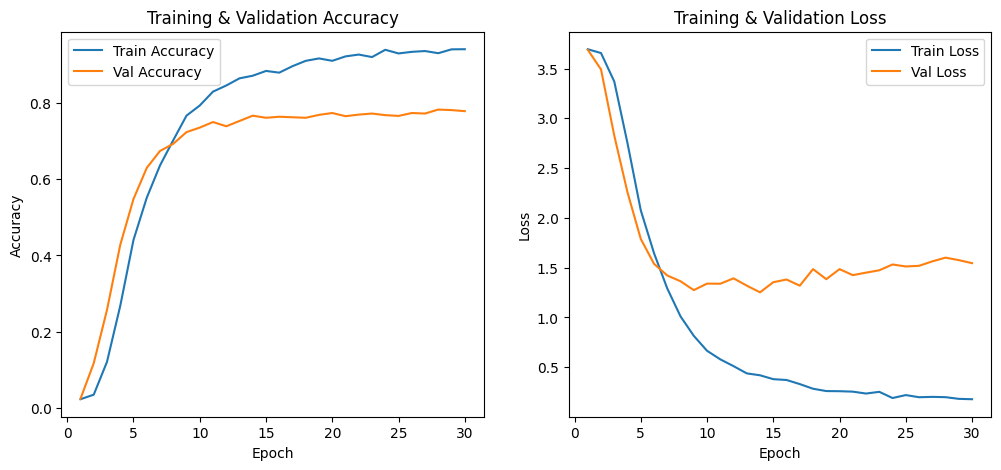

In [31]:
plot_training(cnn_history)

karena data terlalu besar dan RAM tidak cukup, maka diterapkan batching data supaya RAM tidak meledak.

Found 4800 files belonging to 40 classes.
Kelas terdeteksi: 40
Sedang melakukan prediksi...
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step

=== Classification Report (SimpleCNN) ===
              precision    recall  f1-score   support

         001       0.54      0.78      0.64       120
         002       0.31      0.17      0.22       120
         003       0.38      0.54      0.45       120
         004       0.23      0.19      0.21       120
         005       0.14      0.28      0.19       120
         006       0.77      0.66      0.71       120
         007       0.90      0.89      0.90       120
         008       0.08      0.12      0.10       120
         009       0.32      0.33      0.32       120
         010       0.86      0.79      0.82       120
         011       0.47      0.72      0.57       120
         012       0.45      0.33      0.38       120
         013       0.54      0.51      0.52       120
         014       0.29      0.43      0.35       120
         015

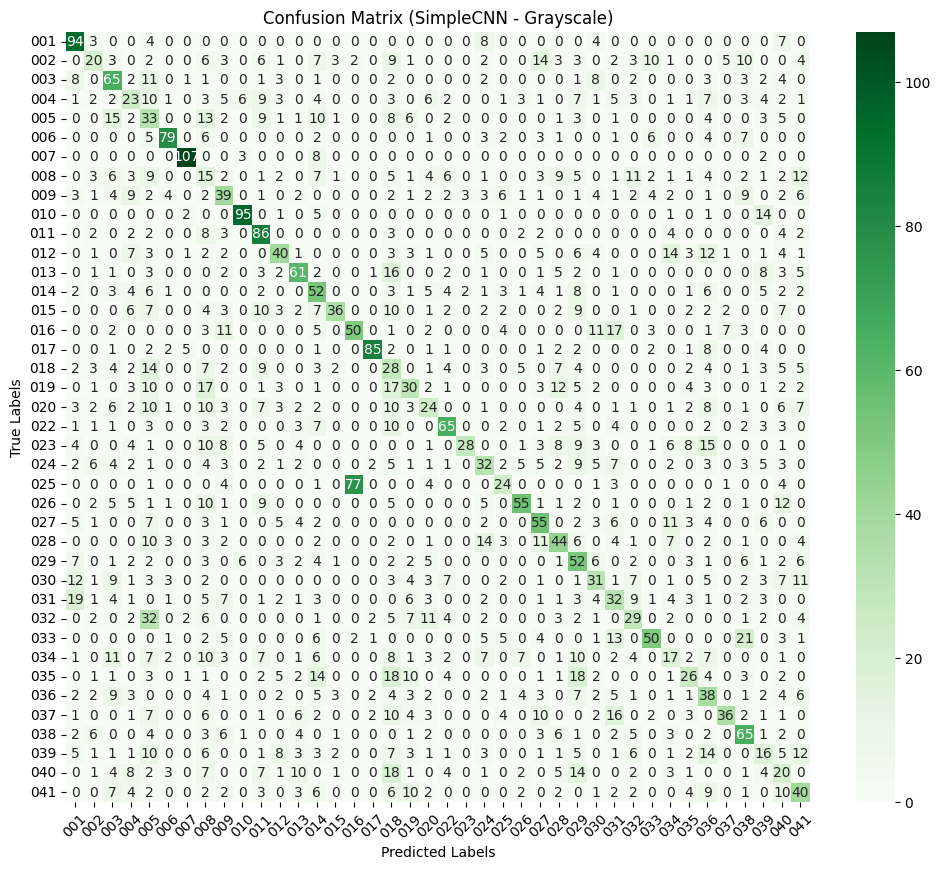

In [32]:
# --- 1. KONFIGURASI ---
# Pastikan path ini mengarah ke folder validasi/test Anda
TEST_DIR = '/content/dataset_augmented_split/test'
BATCH_SIZE = 32
IMG_HEIGHT = 256 # Harus sama dengan input shape model SimpleCNN
IMG_WIDTH = 256

# --- 2. LOAD DATASET (KHUSUS EVALUASI) ---
test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',  # <--- PENTING: Grayscale (1 Channel)
    shuffle=False,           # <--- WAJIB FALSE: Agar urutan prediksi dan label cocok
    seed=123
)

# --- 3. AMBIL NAMA KELAS ---
# Dilakukan sebelum mapping/normalisasi
class_names = test_ds_raw.class_names
print(f"Kelas terdeteksi: {len(class_names)}")

# --- 4. PREPROCESSING (NORMALISASI) ---
# Samakan dengan preprocessing saat training (Rescaling 1./255)
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_ds = test_ds_raw.map(lambda x, y: (normalization_layer(x), y))

# --- 5. PREDIKSI (STREAMING) ---
print("Sedang melakukan prediksi...")
# Gunakan variable model yang sudah di-training (model_cnn_finetuned)
predictions = cnn_model_praprocessed.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# --- 6. AMBIL LABEL ASLI (TRUE LABELS) ---
# Ekstraksi label langsung dari dataset tanpa load gambar ke memori
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# --- 7. PRINT CLASSIFICATION REPORT (BARU) ---
print("\n=== Classification Report (SimpleCNN) ===")
# target_names akan mengganti angka 0,1,2 menjadi label kelas '001', '002', dst
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print(report)

# --- 8. PLOT CONFUSION MATRIX ---
cm = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', # Pakai warna beda (Hijau) biar variasi
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SimpleCNN - Grayscale)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

### mobilenet + praproses

In [33]:
import tensorflow as tf
import pathlib

# --- KONFIGURASI ---
BATCH_SIZE = 32        # Jumlah gambar per batch (coba 16 atau 32 jika memori terbatas)
IMG_HEIGHT = 224       # Sesuaikan dengan input model (misal: 224, 224)
IMG_WIDTH = 224
TRAIN_DIR = '/content/dataset_augmented_split/train' # Ganti dengan path folder dataset
VAL_DIR = '/content/dataset_augmented_split/val' # Ganti dengan path folder dataset

# --- MEMBUAT DATASET (PIPELINE) ---
# 1. Load Training Data
train_ds = tf.keras.utils.image_dataset_from_directory(
  TRAIN_DIR,
  color_mode='rgb',
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

# 2. Load Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
  VAL_DIR,
  color_mode='rgb',
  shuffle=False,
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

# --- MENAMPILKAN INFO KELAS ---
class_names = train_ds.class_names
print(f"Jumlah kelas terdeteksi: {len(class_names)}")
print(f"Contoh kelas: {class_names[:5]}")

Found 3360 files belonging to 40 classes.
Found 1440 files belonging to 40 classes.
Jumlah kelas terdeteksi: 40
Contoh kelas: ['001', '002', '003', '004', '005']


In [34]:
AUTOTUNE = tf.data.AUTOTUNE

# Fungsi untuk normalisasi (opsional, jika model butuh input 0-1)
# MobileNet biasanya punya preprocessing sendiri, tapi ini standar rescaling:
normalization_layer = tf.keras.layers.Rescaling(1./255)

def prepare_dataset(ds, shuffle=False, augment=False):
    # Rescaling (opsional, tergantung model)
    ds = ds.map(lambda x, y: (normalization_layer(x), y))

    if shuffle:
        ds = ds.shuffle(1000)

    # Caching: Menyimpan data di memori setelah epoch pertama (jika muat)
    ds = ds.cache()

    # Prefetching: Menyiapkan batch berikutnya di background
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Terapkan optimasi
train_ds = prepare_dataset(train_ds, shuffle=True)
val_ds = prepare_dataset(val_ds)

In [35]:
# --- 1. AMBIL INFO DARI DATASET ---
# Mengambil jumlah kelas secara otomatis dari folder
num_classes = len(class_names)

# Pastikan input shape SAMA PERSIS dengan IMG_HEIGHT/WIDTH di konfigurasi dataset sebelumnya
# Jika sebelumnya Anda set 224, maka disini wajib 224.
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

print(f"Menggunakan {num_classes} kelas: {class_names}")
print(f"Input shape model: {input_shape}")

# --- 2. BUILD MODEL ---
def build_mobilenet(input_shape, num_classes):
    # Input Layer
    inputs = Input(shape=input_shape)

    # Preprocessing khusus MobileNetV2 (Opsional tapi direkomendasikan)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)

    base = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights="imagenet",
        input_tensor=x # Hubungkan preprocessing ke base model
    )

    base.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=out) # inputs dari layer Input awal

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy", # Cocok karena label kita berupa integer (0, 1, 2...)
        metrics=["accuracy"]
    )
    return model

# Buat model
mobilenet = build_mobilenet(input_shape, num_classes)

# --- 3. TRAIN MODEL (UPDATED) ---
# Perhatikan: train_labels dan batch_size DIHAPUS
mobilenet_hist = mobilenet.fit(
    train_ds,                  # Dataset training (sudah berisi gambar & label)
    validation_data=val_ds,    # Dataset validasi
    epochs=50
)

# --- 4. SAVE & DOWNLOAD ---
mobilenet.save('mobilenet.h5')
try:
    files.download('mobilenet.h5')
except ImportError:
    print("Download file hanya jalan di Google Colab. File tersimpan lokal sebagai 'mobilenet.h5'")

Menggunakan 40 kelas: ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041']
Input shape model: (224, 224, 3)
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.0228 - loss: 3.9964 - val_accuracy: 0.0326 - val_loss: 3.7405
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.0214 - loss: 3.8764 - val_accuracy: 0.0444 - val_loss: 3.7212
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.0334 - loss: 3.8487 - val_accuracy: 0.0507 - val_loss: 3.7042
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.0341 - loss: 3.8092 - val_accuracy: 0.0625 - val_loss: 3.6906
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.0326 - loss: 3.7789 - val_accur

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

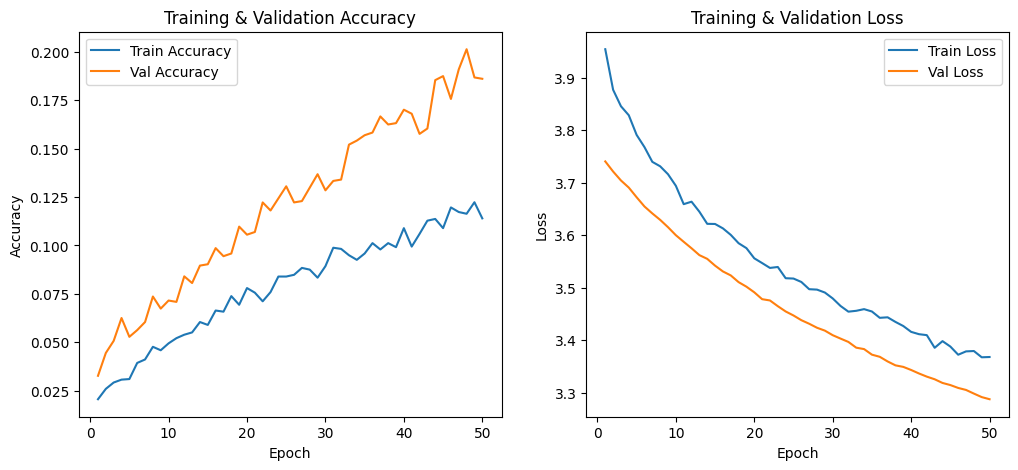

In [36]:
plot_training(mobilenet_hist)

Found 4800 files belonging to 40 classes.
Kelas terdeteksi: 40
Sedang melakukan prediksi...
150/150 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step

=== Classification Report ===
              precision    recall  f1-score   support

         001       0.23      0.36      0.28       120
         002       0.00      0.00      0.00       120
         003       0.11      0.32      0.17       120
         004       0.00      0.00      0.00       120
         005       0.00      0.00      0.00       120
         006       0.28      0.08      0.13       120
         007       0.00      0.00      0.00       120
         008       0.09      0.34      0.15       120
         009       0.00      0.00      0.00       120
         010       0.88      0.12      0.22       120
         011       0.33      0.76      0.46       120
         012       0.00      0.00      0.00       120
         013       0.00      0.00      0.00       120
         014       0.08      0.27      0.12       120
         015       0.32 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


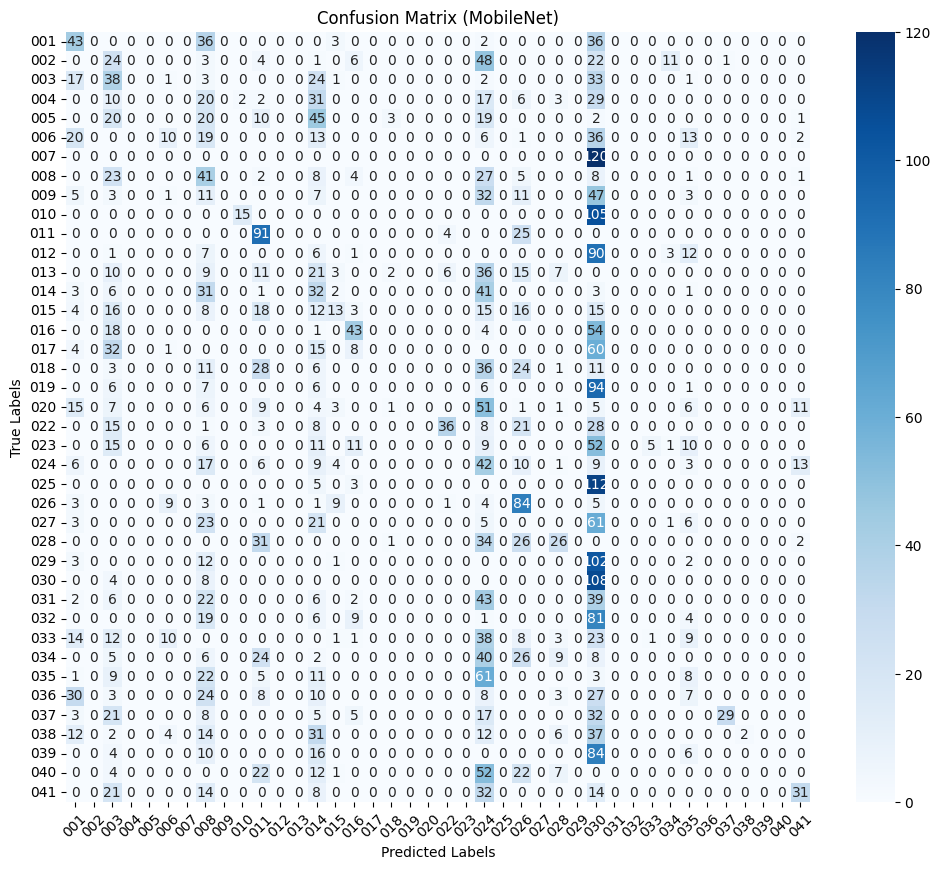

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf

# --- 1. MEMBUAT PIPELINE DATA TEST ---
# Ganti path ini ke folder test Anda
TEST_DIR = '/content/dataset_augmented_split/test'
BATCH_SIZE = 32

# Load dataset (Objek Original)
test_ds_original = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    shuffle=False,         # WAJIB FALSE
    seed=123
)

# --- [PENTING] AMBIL NAMA KELAS DISINI ---
# Kita ambil sebelum dataset di-map atau diubah
class_names = test_ds_original.class_names
print(f"Kelas terdeteksi: {len(class_names)}")

# --- 2. PREPROCESSING ---
# Normalisasi
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_ds = test_ds_original.map(lambda x, y: (normalization_layer(x), y))

# --- 3. MELAKUKAN PREDIKSI ---
print("Sedang melakukan prediksi...")
test_preds = mobilenet.predict(test_ds)
test_preds_classes = np.argmax(test_preds, axis=1)

# --- 4. MENGAMBIL LABEL ASLI (TRUE LABELS) ---
# Kita ambil label dari dataset yang sudah di-load
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# --- 5. PRINT CLASSIFICATION REPORT ---
print("\n=== Classification Report ===")
report = classification_report(true_labels, test_preds_classes, target_names=class_names)
print(report)

# --- 5. MEMBUAT CONFUSION MATRIX ---
cm = confusion_matrix(true_labels, test_preds_classes)

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,  # Gunakan variabel class_names yang sudah kita simpan di atas
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (MobileNet)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()



## Evaluasi

Berikut adalah model dengan finetune/penyesuaian arsitektur untuk melihat apakah ada peningkatan.

### Finetuned + new architecture SimpleCNN

In [38]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [39]:
# --- 1. KONFIGURASI ---
BATCH_SIZE = 32
IMG_HEIGHT = 256  # Sesuai input_shape model Anda (256)
IMG_WIDTH = 256
TRAIN_DIR = '/content/dataset_augmented_split/train'
VAL_DIR = '/content/dataset_augmented_split/val'

# --- 2. LOAD DATA (HEMAT RAM & GRAYSCALE) ---
# Training Data
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    color_mode='grayscale',  # <--- PENTING: Mode Grayscale (1 Channel)
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

# Validation Data
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    color_mode='grayscale',  # <--- PENTING: Mode Grayscale
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,           # Validation jangan di-shuffle
    seed=123
)

# --- 3. AMBIL INFO KELAS (Sebelum Optimasi) ---
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Jumlah kelas: {num_classes}")
print(f"Input Shape Dataset: {train_ds.element_spec[0].shape}")
# Seharusnya output: (None, 256, 256, 1)

# --- 4. OPTIMASI PERFORMA & NORMALISASI ---
AUTOTUNE = tf.data.AUTOTUNE

# Layer Normalisasi (0-255 menjadi 0-1)
normalization_layer = tf.keras.layers.Rescaling(1./255)

def prepare_dataset(ds, shuffle=False):
    # Normalisasi
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Caching & Prefetching
    ds = ds.cache()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_ds, shuffle=True)
val_ds = prepare_dataset(val_ds, shuffle=False)

# --- 5. BANGUN ARSITEKTUR MODEL ---
model_cnn_finetuned = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # --- REFACTOR POINT: FLATTEN -> GAP ---
    GlobalAveragePooling2D(),

    # Kita tetap butuh Dense layer untuk memproses hasil ekstraksi fitur dari GAP
    Dense(128, activation='relu'),

    # Dropout tetap penting untuk mencegah overfitting pada dense layer
    Dropout(0.5),

    # Output Layer
    Dense(num_classes, activation='softmax')
])

model_cnn_finetuned.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("=== Model Summary ===")
model_cnn_finetuned.summary()

# --- 6. CALLBACK ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- 7. TRAINING ---
print("\n=== Mulai Training ===")
history = model_cnn_finetuned.fit(
    train_ds,                   # Gunakan dataset pipeline
    validation_data=val_ds,     # Gunakan dataset pipeline
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
    # Note: batch_size dihapus karena sudah ada di dataset
)

# save model
# --- 4. SAVE & DOWNLOAD ---
model_cnn_finetuned.save('model_cnn_finetuned.h5')
try:
    files.download('model_cnn_finetuned.h5')
except ImportError:
    print("Download file hanya jalan di Google Colab. File tersimpan lokal sebagai 'model_cnn_finetuned.h5'")


Found 3360 files belonging to 40 classes.
Found 1440 files belonging to 40 classes.
Jumlah kelas: 40
Input Shape Dataset: (None, 256, 256, 1)
=== Model Summary ===


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 254, 254, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 40)             │         5,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 573,480 (2.19 MB)

 Trainable params: 573,480 (2.19 MB)

 Non-trainable params: 0 (0.00 B)


=== Mulai Training ===
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.0173 - loss: 3.6894 - val_accuracy: 0.0285 - val_loss: 3.6814
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.0359 - loss: 3.6474 - val_accuracy: 0.0521 - val_loss: 3.5436
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.0524 - loss: 3.5682 - val_accuracy: 0.0715 - val_loss: 3.4098
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - accuracy: 0.0690 - loss: 3.4431 - val_accuracy: 0.1111 - val_loss: 3.2417
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.1070 - loss: 3.2569 - val_accuracy: 0.1771 - val_loss: 3.0194
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.1399 - loss: 3.1092 - val_accuracy: 0.2354 - val_loss: 2.8646
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.1768 - loss: 2.9469 - val_accuracy: 0.2937 - val_loss: 2.6122
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.2373 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model baru membuang sekitar 98% parameter sampah yang tidak perlu, membuat model jauh lebih ringan dan cepat saat diproses.

a. Training:

**Model Lama**: Karena punya hampir 2 juta parameter di satu layer, model punya kapasitas memori yang terlalu besar. Ia cenderung menghafal data training (termasuk noise/gangguan gambar) daripada mempelajari pola. Ini yang membuat grafik validasi Anda stuck atau malah naik.

**Model FIne tuned**: Dengan parameter yang terbatas, model "dipaksa" untuk menjadi pintar. Ia tidak bisa menghafal posisi pixel, jadi ia harus benar-benar belajar bentuk/tekstur umum agar loss-nya turun.

b. Kestabilan Training

**Model Lama**: Grafik Loss validasi biasanya fluktuatif (naik-turun tajam) dan menjauh dari training loss (gap lebar).

**Model Fine tuned**: Grafik Loss validasi biasanya lebih mulus, lebih dekat dengan training loss, dan konvergen (menurun) dengan lebih stabil.

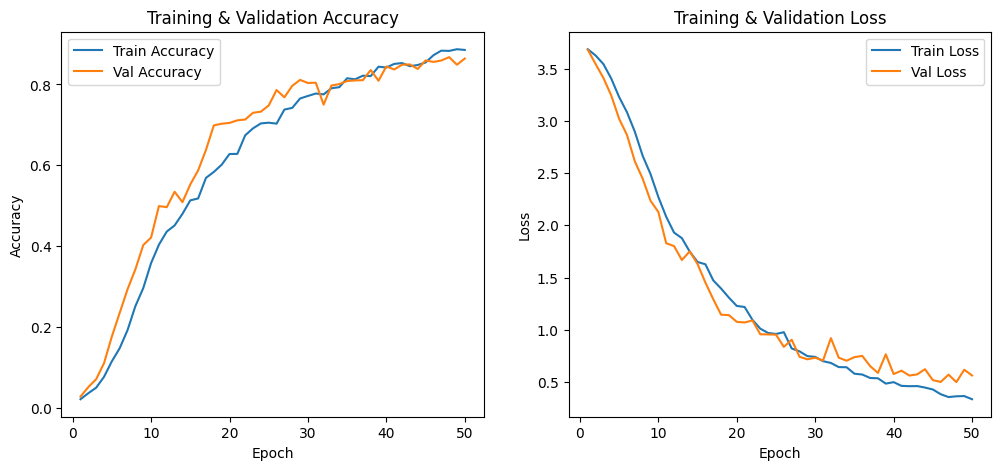

In [40]:
plot_training(history)

Found 4800 files belonging to 40 classes.
Kelas terdeteksi: 40
Sedang melakukan prediksi...
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step

=== Classification Report (SimpleCNN) ===
              precision    recall  f1-score   support

         001       0.85      0.75      0.80       120
         002       0.71      0.31      0.43       120
         003       0.55      0.59      0.57       120
         004       0.32      0.33      0.32       120
         005       0.26      0.56      0.35       120
         006       0.92      0.87      0.89       120
         007       0.81      0.97      0.88       120
         008       0.12      0.17      0.14       120
         009       0.33      0.38      0.36       120
         010       0.90      0.98      0.94       120
         011       0.65      0.99      0.79       120
         012       0.60      0.40      0.48       120
         013       0.44      0.68      0.53       120
         014       0.60      0.81      0.69       120
         015

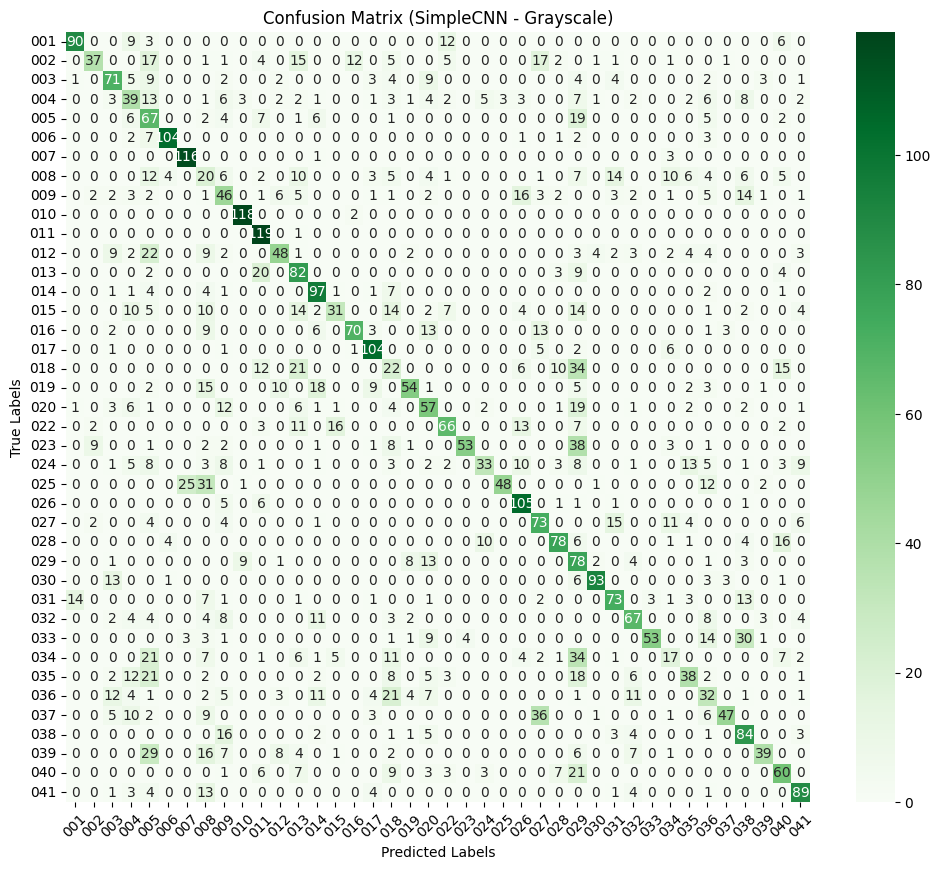

In [41]:
# --- 1. KONFIGURASI ---
# Pastikan path ini mengarah ke folder validasi/test Anda
TEST_DIR = '/content/dataset_augmented_split/test'
BATCH_SIZE = 32
IMG_HEIGHT = 256 # Harus sama dengan input shape model SimpleCNN
IMG_WIDTH = 256

# --- 2. LOAD DATASET (KHUSUS EVALUASI) ---
# Note: Gunakan objek baru agar tidak tercampur dengan settingan training
test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',  # <--- PENTING: Grayscale (1 Channel)
    shuffle=False,           # <--- WAJIB FALSE: Agar urutan prediksi dan label cocok
    seed=123
)

# --- 3. AMBIL NAMA KELAS ---
# Dilakukan sebelum mapping/normalisasi
class_names = test_ds_raw.class_names
print(f"Kelas terdeteksi: {len(class_names)}")

# --- 4. PREPROCESSING (NORMALISASI) ---
# Samakan dengan preprocessing saat training (Rescaling 1./255)
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_ds = test_ds_raw.map(lambda x, y: (normalization_layer(x), y))

# --- 5. PREDIKSI (STREAMING) ---
print("Sedang melakukan prediksi...")
# Gunakan variable model yang sudah di-training (model_cnn_finetuned)
predictions = model_cnn_finetuned.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# --- 6. AMBIL LABEL ASLI (TRUE LABELS) ---
# Ekstraksi label langsung dari dataset tanpa load gambar ke memori
true_labels = np.concatenate([y for x, y in test_ds], axis=0)

# --- 7. PRINT CLASSIFICATION REPORT (BARU) ---
print("\n=== Classification Report (SimpleCNN) ===")
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print(report)

# --- 7. PLOT CONFUSION MATRIX ---
cm = confusion_matrix(true_labels, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', # Pakai warna beda (Hijau) biar variasi
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SimpleCNN - Grayscale)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

### Mobilenet finetuned

Tidak bisa diimplementasi karena keterbatasan RAM di google colab

## Test Rekognisi dengan Kelas Unknown dan Kelas Genuine

tes ini dilakukan sebagai simulasi penggunaan model di implementasi nyata.

Konfigurasi Label: 40 kelas.

Memuat bobot model...
✅ Baseline CNN Loaded
✅ CNN Finetuned Loaded
✅ MobileNet Loaded

PROCESSING: GENUINE TEST


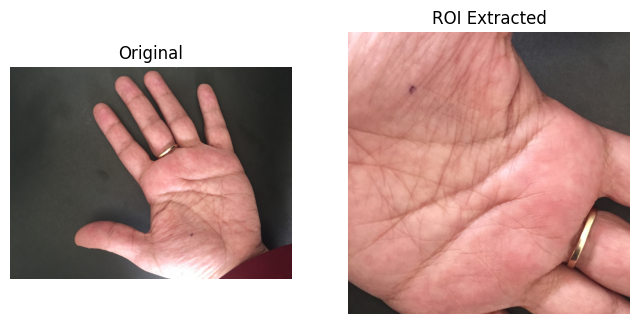


--- Hasil Baseline CNN ---
🔴 STATUS: UNKNOWN / IMPOSTOR (Conf: 37.85%)
   Kelas 031: 37.85% ███████
   Kelas 038: 32.36% ██████
   Kelas 008: 21.40% ████

--- Hasil CNN Finetuned ---
🟢 STATUS: 027 (Conf: 54.40%)
   Kelas 027: 54.40% ██████████
   Kelas 017: 24.94% ████
   Kelas 003: 17.94% ███

--- Hasil MobileNetV2 ---
🟢 STATUS: 026 (Conf: 88.45%)
   Kelas 026: 88.45% █████████████████
   Kelas 038: 11.55% ██
   Kelas 024: 0.00% 

PROCESSING: IMPOSTOR TEST


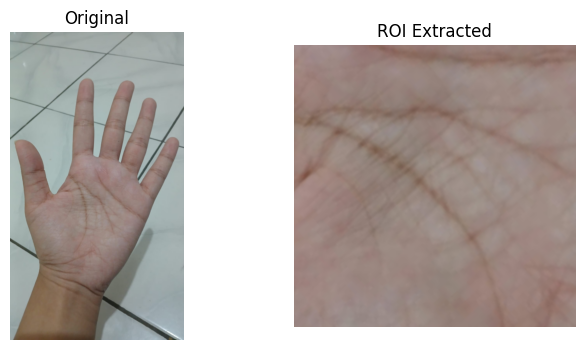


--- Hasil Baseline CNN ---
🔴 STATUS: UNKNOWN / IMPOSTOR (Conf: 5.04%)
   Kelas 029: 5.04% █
   Kelas 014: 5.03% █
   Kelas 008: 4.82% 

--- Hasil CNN Finetuned ---
🟢 STATUS: 010 (Conf: 96.80%)
   Kelas 010: 96.80% ███████████████████
   Kelas 030: 3.03% 
   Kelas 014: 0.10% 

--- Hasil MobileNetV2 ---
🟢 STATUS: 026 (Conf: 100.00%)
   Kelas 026: 100.00% ███████████████████
   Kelas 038: 0.00% 
   Kelas 024: 0.00% 


In [50]:
import cv2
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from matplotlib import pyplot as plt
import os

# ==========================================
# 1. KONFIGURASI KELAS
# ==========================================
# Total kelas aktif (41 total - 1 dihapus = 40)
NUM_CLASSES = 40

# Membuat list nama kelas manual: 001 s.d 041, KECUALI 021
class_names = []
for i in range(1, 42):
    if i == 21: continue
    class_names.append(f"{i:03d}")

print(f"Konfigurasi Label: {len(class_names)} kelas.")

# ==========================================
# 2. DEFINISI ARSITEKTUR MODEL
# ==========================================

def build_baseline_cnn(num_classes):
    """Arsitektur Baseline CNN (Sesuai snippet Anda)"""
    tf.keras.backend.clear_session()
    model = Sequential([
        # Input Shape: 256x256x1 (Grayscale)
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])
    return model

def build_mobilenet(num_classes):
    """Arsitektur MobileNetV2 (Sesuai snippet Anda)"""
    input_shape = (224, 224, 3)
    inputs = Input(shape=input_shape)

    # Preprocessing khusus MobileNetV2
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)

    base = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights=None, # Kita load manual, set None dulu
        input_tensor=x
    )
    base.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.3)(x)
    out = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=out)
    return model

def build_cnn_finetuned(num_classes):
    """Arsitektur CNN Finetuned (Sesuai snippet Anda)"""
    model = Sequential([
        # Input Shape: 256x256x1 (Grayscale)
        Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        # --- REFACTOR POINT: FLATTEN -> GAP ---
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# ==========================================
# 3. LOAD WEIGHTS
# ==========================================
print("\nMemuat bobot model...")
models_loaded = {}

# --- A. Baseline CNN ---
try:
    m_baseline = build_baseline_cnn(NUM_CLASSES)
    # Pastikan nama file sesuai dengan yang ada di Files Colab (misal: 'cnn_model.h5' atau 'cnn_model_praprocessed.h5')
    m_baseline.load_weights('cnn_model.h5')
    models_loaded['Baseline CNN'] = m_baseline
    print("✅ Baseline CNN Loaded")
except Exception as e:
    print(f"❌ Gagal load Baseline CNN: {e}")

# --- B. Simple CNN Finetuned ---
try:
    m_finetuned = build_cnn_finetuned(NUM_CLASSES)
    # Pastikan nama file sesuai (misal: 'model_cnn_finetuned.h5')
    m_finetuned.load_weights('model_cnn_finetuned.h5')
    models_loaded['CNN Finetuned'] = m_finetuned
    print("✅ CNN Finetuned Loaded")
except Exception as e:
    print(f"❌ Gagal load CNN Finetuned: {e}")

# --- C. MobileNet ---
try:
    m_mobile = build_mobilenet(NUM_CLASSES)
    # Pastikan nama file sesuai (misal: 'mobilenet (1).h5')
    m_mobile.load_weights('mobilenet.h5')
    models_loaded['MobileNetV2'] = m_mobile
    print("✅ MobileNet Loaded")
except Exception as e:
    print(f"❌ Gagal load MobileNet: {e}")


# ==========================================
# 4. ROI EXTRACTION & HELPER FUNCTIONS
# ==========================================
YCrCb_SKIN_LOWER = np.array([30, 138, 80], dtype=np.uint8)
YCrCb_SKIN_HIGHER = np.array([255, 180, 127], dtype=np.uint8)
PALM_ROI_SIZE = 600

def get_clean_mask(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    mask = cv2.inRange(ycrcb, YCrCb_SKIN_LOWER, YCrCb_SKIN_HIGHER)
    mask = cv2.medianBlur(mask, 11)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    clean = np.zeros_like(mask)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        cv2.drawContours(clean, [largest], -1, 255, -1)
    return clean

def get_hand_mask_centroid(mask):
    M = cv2.moments(mask)
    if M["m00"] == 0: return None
    return (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

def get_robust_valleys(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return []
    cnt = max(contours, key=cv2.contourArea)
    hull = cv2.convexHull(cnt, returnPoints=False)
    defects = cv2.convexityDefects(cnt, hull)
    if defects is None: return []
    raw_pts = []
    for i in range(defects.shape[0]):
        s, e, f, d = defects[i, 0]
        depth = d / 256.0
        if depth > 15: raw_pts.append(tuple(cnt[f][0]))
    if len(raw_pts) < 3: return raw_pts
    valleys_center = np.mean(raw_pts, axis=0)
    distances = [np.linalg.norm(np.array(p) - valleys_center) for p in raw_pts]
    mean_dist = np.mean(distances)
    return [p for i, p in enumerate(raw_pts) if distances[i] < mean_dist * 1.5]

def extract_roi_using_centroid(img, pts, hand_centroid):
    if len(pts) < 2 or hand_centroid is None: return None
    pts_arr = np.array(pts)
    c_hand = np.array(hand_centroid)
    v_center = np.mean(pts_arr, axis=0)
    axis_vector = c_hand - v_center
    angle = math.degrees(math.atan2(axis_vector[1], axis_vector[0])) - 90
    roi_center = v_center + (axis_vector * 0.9)
    roi_center = (int(roi_center[0]), int(roi_center[1]))
    M = cv2.getRotationMatrix2D(roi_center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    max_dist = max([np.linalg.norm(np.array(p1)-np.array(p2)) for p1 in pts for p2 in pts]) if pts else 0
    roi_side = int(max_dist * 0.7) if max_dist > 0 else 300
    x, y = int(roi_center[0] - roi_side / 2), int(roi_center[1] - roi_side / 2)
    roi = rotated[max(0, y):y + roi_side, max(0, x):x + roi_side]
    if roi.size == 0 or roi.shape[0] < 10: return None
    return cv2.resize(roi, (PALM_ROI_SIZE, PALM_ROI_SIZE))

def get_roi_from_image(image_path):
    img = cv2.imread(image_path)
    if img is None: return None
    mask = get_clean_mask(img)
    centroid = get_hand_mask_centroid(mask)
    pts = get_robust_valleys(mask)
    roi = extract_roi_using_centroid(img, pts, centroid)
    return roi, img

# ==========================================
# 5. EXECUTION & PREDICTION
# ==========================================

def predict_and_display(roi, original_img, title):
    print(f"\n{'='*40}\nPROCESSING: {title}\n{'='*40}")

    # Visualisasi
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1); plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title("Original")
    plt.subplot(1, 2, 2); plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title("ROI Extracted")
    plt.show()

    # Preprocessing Batches
    # 1. Grayscale for CNNs
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi_cnn = cv2.resize(roi_gray, (256, 256)).astype('float32') / 255.0
    batch_cnn = np.expand_dims(np.expand_dims(roi_cnn, axis=-1), axis=0)

    # 2. RGB for MobileNet
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi_mobile = cv2.resize(roi_rgb, (224, 224))
    batch_mobile = np.expand_dims(roi_mobile, axis=0)

    # Loop Prediksi
    for name, model in models_loaded.items():
        # Pilih batch sesuai jenis model
        input_batch = batch_mobile if "MobileNet" in name else batch_cnn

        # Predict
        preds = model.predict(input_batch, verbose=0)[0]

        # Hasil
        top_indices = preds.argsort()[-3:][::-1]
        top_idx = top_indices[0]
        top_conf = preds[top_idx]
        top_label = class_names[top_idx]

        print(f"\n--- Hasil {name} ---")
        if top_conf < 0.50:
            print(f"🔴 STATUS: UNKNOWN / IMPOSTOR (Conf: {top_conf:.2%})")
        else:
            print(f"🟢 STATUS: {top_label} (Conf: {top_conf:.2%})")

        for i in top_indices:
            print(f"   Kelas {class_names[i]}: {preds[i]:.2%} {'█' * int(preds[i]*20)}")

# --- USER INPUT SECTION ---
# Pastikan path ini benar sesuai file di Colab
genuine_path = '/content/011_S_L_29.JPG'
impostor_path = '/content/Unknown_001.jpeg'

targets = [("GENUINE TEST", genuine_path), ("IMPOSTOR TEST", impostor_path)]

for title, path in targets:
    if os.path.exists(path):
        res = get_roi_from_image(path)
        if res:
            predict_and_display(res[0], res[1], title)
        else:
            print(f"❌ Gagal Extract ROI: {path}")
    else:
        print(f"⚠️ File tidak ditemukan: {path}")

## Kesimpulan

Perbandingan Kinerja Model (berdasarkan Macro F1-Score):

- Baseline → 0.60
- Baseline + praproses → 0.38
- MobileNetV2 + praproses → 0.11
- Baseline + fine-tuning + praproses → 0.55

Meskipun model baseline menghasilkan nilai Macro F1-Score tertinggi, performa ini belum dapat dianggap valid karena model mengalami overfitting yang cukup signifikan, sehingga kemampuan generalisasinya terhadap data baru masih rendah.

Pada model baseline + praproses, terjadi penurunan performa. Hal ini kemungkinan disebabkan oleh peningkatan ukuran dataset hingga enam kali lipat, yang membuat distribusi data menjadi lebih beragam dan kompleks, sehingga model baseline belum mampu beradaptasi secara optimal terhadap variasi tersebut.

Sementara itu, performa MobileNetV2 + praproses masih sangat rendah. Namun, berdasarkan learning curve yang masih berfluktuasi dan menunjukkan tren peningkatan, terdapat indikasi bahwa model ini berpotensi mencapai performa yang lebih baik apabila dilatih dengan jumlah epoch yang lebih banyak atau dilakukan penyesuaian hyperparameter.

Model baseline + fine-tuning + praproses menunjukkan performa yang paling stabil, dengan tingkat overfitting yang relatif kecil dan hanya mulai terlihat pada epoch ke-48 hingga akhir pelatihan. Hal ini menunjukkan bahwa proses fine-tuning membantu model dalam mencapai keseimbangan yang lebih baik antara kemampuan belajar dan generalisasi.

## Saran

Berdasarkan hasil evaluasi dan analisis kinerja model, disarankan untuk melakukan pelatihan lanjutan (fine-tuning) pada model MobileNetV2 apabila tersedia sumber daya komputasi yang memadai. Penambahan jumlah epoch pelatihan perlu dilakukan untuk mengamati apakah performa model, khususnya nilai Macro F1-Score, dapat meningkat dan melampaui model lainnya. Hal ini didasarkan pada pola learning curve MobileNetV2 yang masih menunjukkan fluktuasi serta tren peningkatan, sehingga model belum mencapai kondisi konvergen secara optimal.

Selain itu, proses fine-tuning dapat dikombinasikan dengan penyesuaian hyperparameter, seperti learning rate, optimizer, dan strategi regularisasi, guna memaksimalkan kemampuan generalisasi model terhadap dataset yang lebih besar dan kompleks. Dengan pendekatan tersebut, diharapkan MobileNetV2 mampu memanfaatkan keunggulan arsitekturnya secara lebih efektif dan menghasilkan performa yang lebih kompetitif dibandingkan model baseline.

## Referensi

    -- dataset
https://github.com/CyberNord/ROI-Extraction-for-Palmprint-Recognition/ -- untuk contoh algoritma ekstraksi ROI